已将 d:\科研\科研 添加到 sys.path
成功导入 KAN、GNN 包装器和自定义损失函数！
--- 阶段 0: 数据准备 ---

Data loaded successfully!
Training data shape:   (766, 26)
Validation data shape: (746, 26)
Testing data shape:    (796, 26)

Identified 12 WiFi features and 9 IMU features.
数据已在DataFrame上完成标准化。
正在从DataFrame创建异构图数据列表 (使用完整融合图)...
数据加载器创建完毕。

--- 阶段 1: 模型实例化 (消融试验: GNN-MLP) ---
端到端模型实例化完成 (GNN-LSTM-MLP)。

--- 开始第一阶段：基础模型训练 (学习核心预测能力) ---


Phase 1 Epochs:  99%|█████████▉| 198/200 [01:05<00:00,  3.01it/s, LR=0.000300, TrainLoss=0.0032, ValLoss=0.0111]



第一阶段早停于 Epoch 199
--- 第一阶段训练完成 ---
最佳基础模型已保存至: Model/phase1_best_model_GMLP.pth

--- 开始第二阶段：物理精调 (学习平滑性与一致性) ---
正在加载第一阶段的最佳模型: Model/phase1_best_model_GMLP.pth


Phase 2 Epochs:  15%|█▌        | 15/100 [00:05<00:29,  2.83it/s, LR=0.000003, TrainLoss=0.0037, ValLoss=0.0109]



第二阶段早停于 Epoch 16
--- 第二阶段精调完成 ---
最佳精调模型已保存至: Model/phase2_finetuned_best_model_GMLP.pth

--- 最终测试: 加载精调后的最佳模型 ---


Testing: 100%|██████████| 6/6 [00:00<00:00, 42.47it/s]


Test Loss: 0.0144
Test results saved to 'results/GMLP_full_graph_MLP_ELU_Lab.csv'

--- 模型评估结果 (GNN-MLP 完整图) ---
X轴均方误差 (MSE X): 1.1961 (米^2)
Y轴均GNN_LSTKAN_with_Attention_V2方误差 (MSE Y): 0.6343 (米^2)
总均方根误差 (RMSE): 0.9567 (米)
平均位移误差 (ADE/FDE): 1.1866 (米)
--------------------


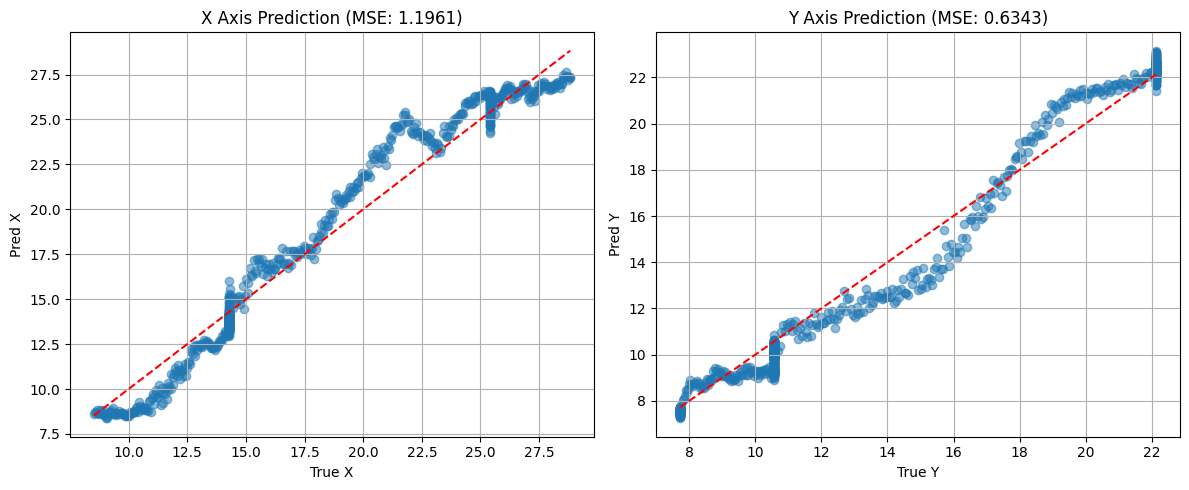

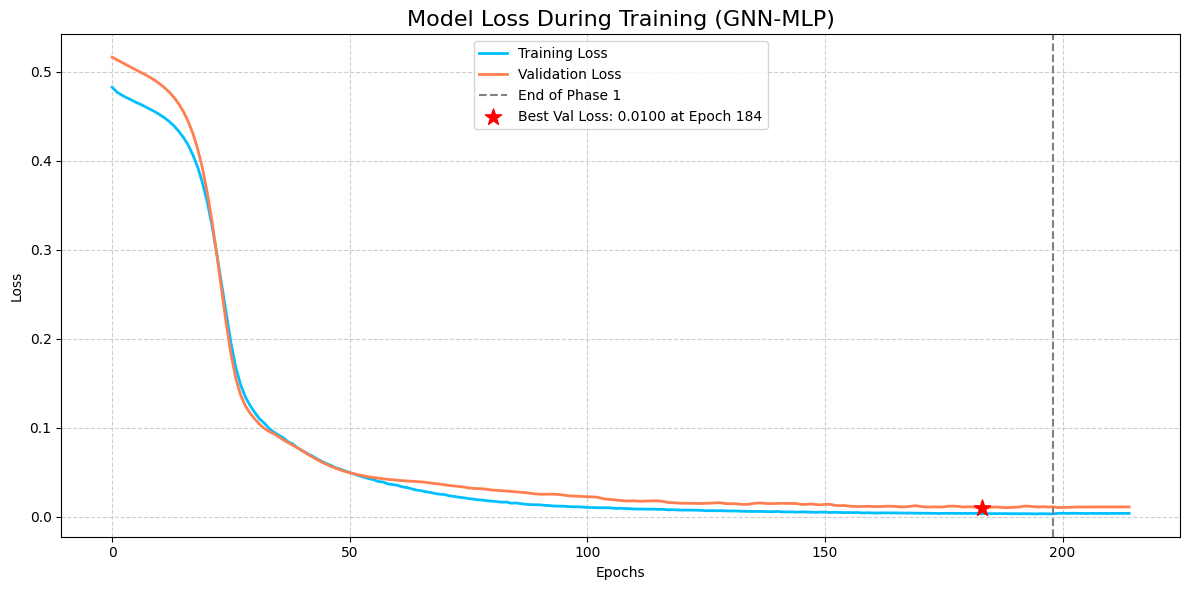

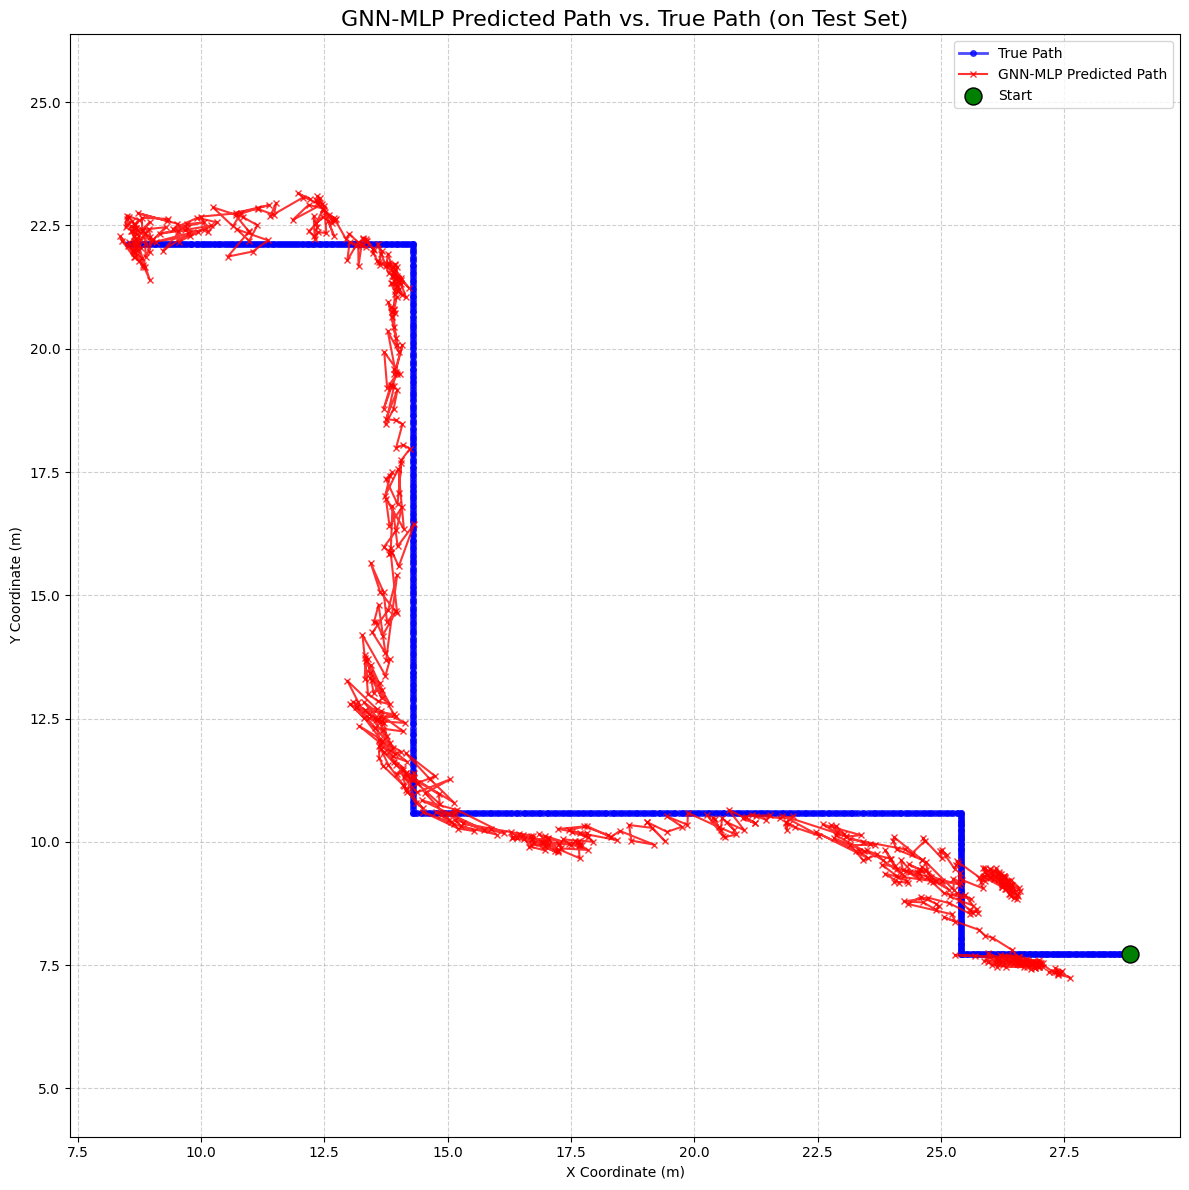

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, HeteroConv
import sys # <-- 【新增】为了导入父目录模块

# ==============================================================================
#                 【A. 依赖的模块、类和函数】
# ==============================================================================

# ------------------------------------------------------------------------------
# 0. 【新增】路径设置 (用于导入上一级目录的损失函数)

# ------------------------------------------------------------------------------
try:
    current_dir = os.getcwd() 
    parent_dir = os.path.dirname(current_dir)
    if parent_dir not in sys.path:
        sys.path.append(parent_dir)
    print(f"已将 {parent_dir} 添加到 sys.path")
except Exception as e:
    print(f"添加 sys.path 失败: {e}")

# ------------------------------------------------------------------------------
# 1. 从您本地文件导入的模块
# ------------------------------------------------------------------------------
try:
    # from loss_function.GNN_LSTM_with_Attention_V2 import GNN_LSTKAN_with_Attention_v2
    from kan_improved import KAN # <-- 我们仍导入它，但在下面不使用
    from loss_function.custom_lossess_v4 import jerk_smoothness_loss_v2, velocity_heading_consistency_loss_v2
    print("成功导入 KAN、GNN 包装器和自定义损失函数！")
except ImportError as e:
    print(f"【警告】无法导入本地模块: {e}")
    # (如果导入失败，您需要确保上面的 sys.path 设置正确)

# ------------------------------------------------------------------------------
# 2. GNNEncoder (来自您的原始代码)
# ------------------------------------------------------------------------------
class GNNEncoder(nn.Module):
    def __init__(self, wifi_input_dim, imu_input_dim, hidden_dim, windows_size, num_layers=2, heads=4, dropout=0.2):
        super().__init__()
        self.wifi_proj = nn.Linear(wifi_input_dim, hidden_dim)
        self.imu_proj = nn.Linear(imu_input_dim, hidden_dim)
        self.positional_embeddings = nn.Embedding(windows_size + 10, hidden_dim)
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()

        for _ in range(num_layers):
            conv = HeteroConv({
                ('wifi', 'temporal', 'wifi'): GATv2Conv(-1, hidden_dim // heads, heads=heads, dropout=dropout, add_self_loops=False, edge_dim=1),
                ('imu', 'temporal', 'imu'): GATv2Conv(-1, hidden_dim // heads, heads=heads, dropout=dropout, add_self_loops=False, edge_dim=1),
                ('imu', 'fuses', 'wifi'): GATv2Conv((-1, -1), hidden_dim // heads, heads=heads, dropout=dropout, add_self_loops=False, edge_dim=2),
                ('wifi', 'fuses', 'imu'): GATv2Conv((-1, -1), hidden_dim // heads, heads=heads, dropout=dropout, add_self_loops=False, edge_dim=1),
            }, aggr='sum')
            self.convs.append(conv)
            self.norms.append(nn.ModuleDict({
                'wifi': nn.LayerNorm(hidden_dim),
                'imu': nn.LayerNorm(hidden_dim),
            }))
        
        self.dropout_p = dropout

    def forward(self, data):
        x_dict, edge_index_dict, edge_attr_dict = data.x_dict, data.edge_index_dict, data.edge_attr_dict

        x_dict['wifi'] = self.wifi_proj(x_dict['wifi'])
        x_dict['imu'] = self.imu_proj(x_dict['imu'])
        x_dict['wifi'] = x_dict['wifi'] + self.positional_embeddings(data['wifi'].time_step)
        x_dict['imu'] = x_dict['imu'] + self.positional_embeddings(data['imu'].time_step)

        for i in range(len(self.convs)):
            residual_dict = {key: x.clone() for key, x in x_dict.items()}
            x_dict_after_conv = self.convs[i](x_dict, edge_index_dict, edge_attr_dict)
            for node_type, x in x_dict_after_conv.items():
                x_processed = F.elu(x)
                x_processed = F.dropout(x_processed, p=self.dropout_p, training=self.training)
                x_dict[node_type] = self.norms[i][node_type](x_processed + residual_dict[node_type])
        
        return x_dict

# ------------------------------------------------------------------------------
# 3. 【新增】MLP 预测器 (作为 KAN 的替代品)
# ------------------------------------------------------------------------------
# (请在此处粘贴上面第一节中提供的 MLPPredictor 类的代码)
class MLPPredictor(nn.Module):
    def __init__(self, layers_hidden, use_lstm=True, lstm_hidden=32, dropout_rate=0.1):
        super().__init__()
        self.use_lstm = use_lstm
        mlp_input_dim = layers_hidden[0]
        if use_lstm:
            self.lstm = nn.LSTM(input_size=layers_hidden[0], hidden_size=lstm_hidden, num_layers=1, batch_first=True)
            mlp_input_dim = lstm_hidden
        else:
            self.lstm = None
        self.dropout = nn.Dropout(dropout_rate)
        layers = []
        current_dim = mlp_input_dim
        for hidden_dim in layers_hidden[1:-1]:
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.ReLU())  
            layers.append(nn.Dropout(dropout_rate))
            current_dim = hidden_dim
        layers.append(nn.Linear(current_dim, layers_hidden[-1]))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):

        if self.use_lstm:
            lstm_out, _ = self.lstm(x) 
            output = self.mlp(lstm_out) 
        
        else:
            output = self.mlp(x) 

        return output
        
        if self.use_lstm:
            lstm_out, _ = self.lstm(x) # lstm_out 是 [B, W, H_lstm]
            # MLP 应该在 *所有* 时间步上应用
            output = self.mlp(lstm_out) # output 是 [B, W, Output_Dim]
            return output
        else:
            # 如果没有 LSTM，MLP 只在最后一个时间步应用
            x_last = x[:, -1, :] # [B, H_gnn]
            output_last = self.mlp(x_last) # [B, Output_Dim]
            
            # 我们需要将它扩展回 [B, W, Output_Dim] 以匹配 KAN 的行为
            # (这是一种 hack，但可以确保与包装器兼容)
            window_size = x.shape[1]
            output_dim = output_last.shape[1]
            output = torch.zeros(x.shape[0], window_size, output_dim, device=x.device)
            output[:, -1, :] = output_last
            return output

    def regularization_loss(self):
        if len(self.mlp) > 0 and isinstance(self.mlp[0], nn.Linear):
             return torch.tensor(0.0, device=self.mlp[0].weight.device)
        return torch.tensor(0.0)

# ------------------------------------------------------------------------------
# 4. 【保留】原始的图构建函数 (来自您的第一个 Prompt)
# ------------------------------------------------------------------------------
def create_asymmetric_fuses_edges(window_size, past_radius, future_radius, device):
    """
    【保留】创建您原始的非对称融合边连接。
    """
    # 1. 为 IMU -> WiFi (因果) 创建边:
    causal_src_nodes, causal_dst_nodes = [], []
    for i in range(window_size):  # 目标时间 (WiFi)
        start = max(0, i - past_radius)
        end = i + 1
        for j in range(start, end):  # 源时间 (IMU)
            causal_src_nodes.append(j)
            causal_dst_nodes.append(i)
    
    edge_index_IMU_to_WiFi = torch.stack([
        torch.tensor(causal_src_nodes, dtype=torch.long, device=device),
        torch.tensor(causal_dst_nodes, dtype=torch.long, device=device)
    ], dim=0)

    # 2. 为 WiFi -> IMU (前瞻) 创建边:
    future_src_nodes, future_dst_nodes = [], []
    for i in range(window_size):  # 目标时间 (IMU)
        start = i
        end = min(window_size, i + future_radius + 1)
        for j in range(start, end):  # 源时间 (WiFi)
            future_src_nodes.append(j)
            future_dst_nodes.append(i)

    edge_index_WiFi_to_IMU = torch.stack([
        torch.tensor(future_src_nodes, dtype=torch.long, device=device),
        torch.tensor(future_dst_nodes, dtype=torch.long, device=device)
    ], dim=0)

    return edge_index_IMU_to_WiFi, edge_index_WiFi_to_IMU

def create_temporal_edges_with_attr(node_features, device):
    """【保留】辅助函数：根据时间戳创建时间边和delta_t边特征"""
    num_nodes = node_features.size(0)
    if num_nodes < 2:
        return torch.empty((2, 0), dtype=torch.long, device=device), \
               torch.empty((0, 1), dtype=torch.float, device=device)

    source_nodes = torch.arange(0, num_nodes - 1, device=device)
    dest_nodes = torch.arange(1, num_nodes, device=device)
    edge_index = torch.stack([source_nodes, dest_nodes], dim=0)
    
    feature_diff = node_features[1:] - node_features[:-1]
    edge_attr = torch.linalg.norm(feature_diff, dim=1).view(-1, 1)

    return edge_index, edge_attr

def create_graph_list_from_df(df, wifi_cols, imu_cols, windows_size, future_steps, device, past_radius, future_radius):
    """
    【保留】您原始的、创建完整图的函数。
    """
    graph_list = []
    num_samples = len(df) - windows_size - future_steps + 1

    accel_cols = [col for col in imu_cols if 'accelerometer' in col]
    gyro_cols = [col for col in imu_cols if 'gyroscope' in col]
    rss_cols = [col for col in wifi_cols if 'RSSI' in col]

    for i in range(num_samples):
        window_df = df.iloc[i : i + windows_size]
        future_df = df.iloc[i + windows_size : i + windows_size + future_steps]
        
        data = HeteroData()
        
        data['wifi'].x = torch.tensor(window_df[wifi_cols].values, dtype=torch.float, device=device)
        data['imu'].x = torch.tensor(window_df[imu_cols].values, dtype=torch.float, device=device)
        
        data['wifi'].time_step = torch.arange(windows_size, device=device)
        data['imu'].time_step = torch.arange(windows_size, device=device)

        # 时间边 (Temporal Edges) - 保持不变
        wifi_edge_index, wifi_edge_attr = create_temporal_edges_with_attr(data['wifi'].x, device)
        imu_edge_index, imu_edge_attr = create_temporal_edges_with_attr(data['imu'].x, device)
        data[('wifi', 'temporal', 'wifi')].edge_index = wifi_edge_index
        data[('imu', 'temporal', 'imu')].edge_index = imu_edge_index
        data[('wifi', 'temporal', 'wifi')].edge_attr = wifi_edge_attr
        data[('imu', 'temporal', 'imu')].edge_attr = imu_edge_attr

        # 融合边 (Fuses Edges) - 【保留】
        edge_index_IMU_to_WiFi, edge_index_WiFi_to_IMU = create_asymmetric_fuses_edges(windows_size, past_radius, future_radius, device)
        
        data[('imu', 'fuses', 'wifi')].edge_index = edge_index_IMU_to_WiFi
        data[('wifi', 'fuses', 'imu')].edge_index = edge_index_WiFi_to_IMU
        
        # for imu -> fuses -> wifi
        forward_src_indices = edge_index_IMU_to_WiFi[0] # 源是 IMU
        motion_intensity = np.linalg.norm(window_df[accel_cols].values, axis=1)
        motion_intensity_tensor = torch.tensor(motion_intensity, dtype=torch.float, device=device)
        rotation_intensity = np.linalg.norm(window_df[gyro_cols].values, axis=1)
        rotation_intensity_tensor = torch.tensor(rotation_intensity, dtype=torch.float, device=device)
        
        fuses_edge_attr_forward = torch.cat([
            motion_intensity_tensor[forward_src_indices].view(-1, 1), 
            rotation_intensity_tensor[forward_src_indices].view(-1, 1)
        ], dim=1)
        data[('imu', 'fuses', 'wifi')].edge_attr = fuses_edge_attr_forward

        # for wifi -> fuses -> imu
        backward_src_indices = edge_index_WiFi_to_IMU[0] # 源是 WiFi
        avg_rssi_per_node = window_df[rss_cols].mean(axis=1).values
        avg_rssi_tensor = torch.tensor(avg_rssi_per_node, dtype=torch.float, device=device)
        fuses_edge_attr_backward = avg_rssi_tensor[backward_src_indices].view(-1, 1)
        data[('wifi', 'fuses', 'imu')].edge_attr = fuses_edge_attr_backward

        # 标签赋值
        labels = future_df[['x_coord', 'y_coord']].values
        data.y = torch.tensor(labels, dtype=torch.float, device=device)
        
        graph_list.append(data)
        
    return graph_list

# ------------------------------------------------------------------------------
# 5. 【保留】GNN 包装器 (使用您修正后的版本)
# ------------------------------------------------------------------------------
# (假设您已导入或定义了 GNN_LSTKAN_with_Attention_V2)
# (为确保脚本完整性，我将粘贴您上次修正的版本)
class Attention(nn.Module):
    """
    一个简单的自注意力层，用于将 [B, W, D] 池化（Pool）为 [B, D]。
    它学习如何对窗口（W）中的时间步进行加权平均。
    """
    def __init__(self, in_features):
        super().__init__()
        # 用于计算每个时间步“重要性”的查询层
        self.query_layer = nn.Linear(in_features, 1)
    
    def forward(self, x):
        # x 形状: [Batch, Window_Size, Features_Dim] (例如 [128, 20, 6])
        
        # 1. 计算注意力权重
        # weights 形状: [B, W, 1]
        weights = self.query_layer(x)
        
        # 2. 应用 Softmax 使权重和为 1
        # scores 形状: [B, W, 1]
        scores = F.softmax(weights, dim=1)
        
        # 3. 计算加权和
        # (x * scores) 是逐元素相乘，形状仍为 [B, W, D]
        # torch.sum(..., dim=1) 在时间维度上求和
        # 最终输出 weighted_sum 形状: [B, D] (例如 [128, 6])
        weighted_sum = torch.sum(x * scores, dim=1)
        
        return weighted_sum, scores

# ==============================================================================
#    【2. 修正后的 GNN_LSTKAN_with_Attention_V2 主类】
# ==============================================================================

class GNN_LSTKAN_with_Attention_V2(nn.Module):
    """
    修正版的 GNN 包装器：
    1. 【修复】__init__ 动态处理 KAN 和 MLP。
    2. 【修复】forward 方法使用 Attention 层进行池化，
       这同时解决了之前的 RuntimeError 和现在的 AttributeError。
    """
    def __init__(self, gnn_encoder, kan_predictor, future_steps):
        super().__init__()
        self.gnn_encoder = gnn_encoder
        self.kan_predictor = kan_predictor # 传入 KAN 或 MLP 实例
        self.future_steps = future_steps

        # --- 【FIX for AttributeError】 ---
        # 动态地从 KAN 或 MLP 获取输出维度
        
        predictor_output_dim = None
        if hasattr(kan_predictor, 'mlp'):
            # 优先检查 MLP (因为 KAN 可能也包装了 MLP)
            # 它是 MLPPredictor，通过 .mlp 属性获取
            # self.mlp 是 nn.Sequential, [-1] 是最后一层 Linear
            predictor_output_dim = kan_predictor.mlp[-1].out_features
            
        elif hasattr(kan_predictor, 'kan_layers'):
            # 它是 KAN，通过 .kan_layers 获取
            # 这是一个脆弱的假设，依赖于 KAN 的内部实现
            # 但我们根据您的错误追踪来修复它
            
            # (一个更鲁棒的检查方式是检查 kan_predictor.layers_hidden)
            try:
                predictor_output_dim = kan_predictor.kan_layers[-1].out_features
            except:
                 raise AttributeError(f"无法从 KAN 实例 {type(kan_predictor)} 中提取 'kan_layers[-1].out_features'。")
        else:
            raise TypeError(f"未知的预测器类型: {type(kan_predictor)}。 无法找到 'kan_layers' 或 'mlp' 属性。")
        # --- 【FIX End】 ---

        # 检查预测器的输出维度是否正确
        # (例如: 3 步 * 2 坐标 = 6)
        if predictor_output_dim != (future_steps * 2):
            print(f"【警告】预测器输出维度 ({predictor_output_dim}) 与 future_steps*2 ({future_steps*2}) 不匹配。")

        # 实例化 Attention 层
        # 它将用于池化 KAN/MLP 的 [B, W, D] 输出
        self.attention = Attention(predictor_output_dim)


    def forward(self, data):
        # 1. 运行 GNN 编码器
        x_dict = self.gnn_encoder(data)
        
        # 2. Reshape 特征
        batch_size = data.num_graphs
        num_wifi_nodes = x_dict['wifi'].shape[0]
        if num_wifi_nodes % batch_size != 0:
            raise ValueError(f"节点数量 ({num_wifi_nodes}) 与 batch_size ({batch_size}) 无法匹配。")
            
        window_size = num_wifi_nodes // batch_size
        hidden_dim = x_dict['wifi'].shape[1]
        
        x_wifi = x_dict['wifi'].view(batch_size, window_size, hidden_dim)
        if 'imu' in x_dict and x_dict['imu'].shape[0] > 0:
            x_imu = x_dict['imu'].view(batch_size, window_size, hidden_dim)
            x_combined = (x_wifi + x_imu) / 2.0
        else:
            x_combined = x_wifi
        
        # 3. 运行预测器 (KAN 或 MLP)
        # 期望输出形状为: [B, W, Output_Dim] (例如 [128, 20, 6])
        raw_output = self.kan_predictor(x_combined)
        
        # 4. 【关键】使用 Attention 层进行池化
        # 这会将 [B, W, D] 转换为 [B, D]
        # (例如 [128, 20, 6] -> [128, 6])
        # 这修复了您之前的 RuntimeError (15360 vs 768)
        final_prediction, _ = self.attention(raw_output)
        
        # 5. Reshape 最终输出
        # 现在 [128, 6] 可以被安全地 view 为 [128, 3, 2]
        main_pred = final_prediction.view(batch_size, self.future_steps, 2)
        
        # 6. 返回值以匹配 (main_pred, _, _) 的解包
        return main_pred, None, None

    def regularization_loss(self):
        """
        将正则化损失的调用传递给内部的预测器。
        (MLPPredictor 会返回 0，KAN 会返回其正则化损失)
        """
        if hasattr(self.kan_predictor, 'regularization_loss'):
            return self.kan_predictor.regularization_loss()
        
        # 如果预测器没有这个方法，返回 0
        return torch.tensor(0.0, device=next(self.parameters()).device)


# ==============================================================================
#                      【B. 原始脚本主要内容】
# ==============================================================================

# ==============================================================================
#                    第一部分: 数据加载与预处理
# ==============================================================================
print("--- 阶段 0: 数据准备 ---")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# direct = "../Datasets/"
filesname = "MLP_Tanh_Lab.csv"
# print(f"filename is {filesname}")
# data = pd.read_csv(direct + filesname)
# train_ratio = 0.8
# val_ratio = 0.1
# data_size = len(data)
# train_end_idx = int(train_ratio * data_size)
# val_end_idx = train_end_idx + int(val_ratio * data_size)
# train_data = data.iloc[:train_end_idx]
# val_data = data.iloc[train_end_idx:val_end_idx]
# test_data = data.iloc[val_end_idx:]

train_data = pd.read_csv(r'../Datasets/Zoulang/train.csv')
val_data = pd.read_csv(r'../Datasets/Zoulang/validation.csv')
test_data = pd.read_csv(r'../Datasets/Zoulang/test.csv')

print("\nData loaded successfully!")
print(f"Training data shape:   {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Testing data shape:    {test_data.shape}")

column_names = train_data.drop(['timestamp','x_coord', 'y_coord'], axis=1).columns.tolist()
coord_cols = ['x_coord', 'y_coord']
# wifi_features = [col for col in column_names if any(sensor in col for sensor in ["rot", "RSSI"])] 
# imu_features = [col for col in column_names if any(sensor in col for sensor in ["accelerometer", "gyroscope"])] 
wifi_features = [col for col in column_names if any(sensor in col for sensor in ["RSSI","distance"])]
imu_features = [col for col in column_names if any(sensor in col for sensor in ["accelerometer", "gyroscope","magnetometer"])]
print(f"\nIdentified {len(wifi_features)} WiFi features and {len(imu_features)} IMU features.")

scaler_wifi = StandardScaler().fit(train_data[wifi_features])
scaler_imu = StandardScaler().fit(train_data[imu_features])
scaler_coords = StandardScaler().fit(train_data[coord_cols])

train_df_scaled = train_data.copy()
val_df_scaled = val_data.copy()
test_df_scaled = test_data.copy()

for df in [train_df_scaled, val_df_scaled, test_df_scaled]:
    df[wifi_features] = scaler_wifi.transform(df[wifi_features])
    df[imu_features] = scaler_imu.transform(df[imu_features])
    df[coord_cols] = scaler_coords.transform(df[coord_cols])
print("数据已在DataFrame上完成标准化。")

windows_size = 40
future_steps = 3
# 【保留】原始图需要半径参数
future_radius = 10
past_radius = 15 

print("正在从DataFrame创建异构图数据列表 (使用完整融合图)...")
# 【保留】调用原始的完整图构建函数
train_data_list = create_graph_list_from_df(train_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu', past_radius, future_radius)
val_data_list = create_graph_list_from_df(val_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu', past_radius, future_radius)
test_data_list = create_graph_list_from_df(test_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu', past_radius, future_radius)


batch_size = 128
train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data_list, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data_list, batch_size=batch_size, shuffle=False)
print("数据加载器创建完毕。")

# ==============================================================================
#                    第二部分: 模型实例化 (【核心修改】)
# ==============================================================================
print("\n--- 阶段 1: 模型实例化 (消融试验: GNN-MLP) ---")
wifi_feat_dim = len(wifi_features)
imu_feat_dim = len(imu_features)
gnn_hidden_dim = 32 
output_dim = future_steps * 2 # (原 kan_output_dim)
gnn_heads = 4
dropout_p = 0.2 # (原 kan_dropout)

# 【保留】使用您原始的 GNNEncoder
gnn_encoder_instance = GNNEncoder(
    wifi_input_dim=wifi_feat_dim,
    imu_input_dim=imu_feat_dim,
    hidden_dim=gnn_hidden_dim,
    windows_size=windows_size,
    num_layers=1,
    heads=gnn_heads,
    dropout=dropout_p
).to(device)

# --- 【核心修改】 ---
# 【注释掉 KAN】
# kan_layers_config = [gnn_hidden_dim, 64, output_dim]
# kan_predictor_instance = KAN(
#     layers_hidden=kan_layers_config,
#     use_lstm=True,
#     lstm_hidden=32, 
#     dropout_rate=dropout_p,
#     grid_size=5,
#     spline_order=3,
# ).to(device)

# 【使用 MLP 替代】
mlp_layers_config = [gnn_hidden_dim, 64, output_dim]
mlp_predictor_instance = MLPPredictor(
    layers_hidden=mlp_layers_config,
    use_lstm=True,
    lstm_hidden=32,
    dropout_rate=dropout_p,
).to(device)
# --- 【修改结束】 ---


# 【保留】使用您原始的包装器
end_to_end_model = GNN_LSTKAN_with_Attention_V2(
    gnn_encoder=gnn_encoder_instance,
    kan_predictor=mlp_predictor_instance, # <-- 【核心修改】传入 MLP
    future_steps=future_steps
).to(device)
print("端到端模型实例化完成 (GNN-LSTM-MLP)。")

# ==============================================================================
#                    第三部分：两阶段训练函数定义
# ==============================================================================

def train_phase_1(model, train_loader, val_loader, initial_lr, weight_decay, num_epochs, patience, kan_reg_weight, lambda_vel, model_save_path):
    """
    【保留】执行第一阶段的训练。
    (MLP的 .regularization_loss() 将返回 0)
    """
    print("\n" + "="*80)
    print("--- 开始第一阶段：基础模型训练 (学习核心预测能力) ---")
    print("="*80)
    
    device = next(model.parameters()).device
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)
    best_val_loss = float('inf')
    patience_counter = 0
    
    train_losses, val_losses = [], []

    epoch_progress = tqdm(range(num_epochs), desc="Phase 1 Epochs")
    for epoch in epoch_progress:
        model.train()
        epoch_train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            main_pred, _, _ = model(batch)
            true_seq = batch.y.view(batch.num_graphs, future_steps, 2)
            
            loss_coord = criterion(main_pred, true_seq)
            pred_vel = (main_pred[:, 1:] - main_pred[:, :-1])
            true_vel = (true_seq[:, 1:] - true_seq[:, :-1])
            loss_vel = criterion(pred_vel, true_vel)
            base_loss = loss_coord + lambda_vel * loss_vel
            
            # 【保留】
            # 这将调用 MLPPredictor.regularization_loss()，返回 0
            reg_loss = model.regularization_loss()
            total_loss = base_loss + kan_reg_weight * reg_loss

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_train_loss += total_loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred_seq, _, _ = model(batch)
                true_seq = batch.y.view(batch.num_graphs, future_steps, 2)
                
                loss_coord_val = criterion(pred_seq, true_seq)
                pred_vel_val = (pred_seq[:, 1:] - pred_seq[:, :-1])
                true_vel_val = (true_seq[:, 1:] - true_seq[:, :-1])
                loss_vel_val = criterion(pred_vel_val, true_vel_val)
                val_loss = loss_coord_val + lambda_vel * loss_vel_val
                epoch_val_loss += val_loss.item()
        
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        epoch_progress.set_postfix(TrainLoss=f'{avg_train_loss:.4f}', ValLoss=f'{avg_val_loss:.4f}', LR=f'{optimizer.param_groups[0]["lr"]:.6f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"\n第一阶段早停于 Epoch {epoch + 1}")
            break
            
    print(f"--- 第一阶段训练完成 ---")
    print(f"最佳基础模型已保存至: {model_save_path}")
    return train_losses, val_losses

def train_phase_2_finetune(pretrained_model_path, model, train_loader, val_loader, finetune_lr, weight_decay, num_epochs, patience, kan_reg_weight, lambda_vel, smooth_weight, consistency_weight, finetuned_model_save_path):
    """
    【保留】执行第二阶段的训练：加载预训练模型，并用包含物理正则项的损失进行精调。
    """
    print("\n" + "="*80)
    print("--- 开始第二阶段：物理精调 (学习平滑性与一致性) ---")
    print("="*80)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"正在加载第一阶段的最佳模型: {pretrained_model_path}")
    # 【保留修正】使用 weights_only=False
    model.load_state_dict(torch.load(pretrained_model_path, weights_only=False)) 
    model.to(device)

    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=finetune_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
    best_val_loss = float('inf')
    patience_counter = 0
    
    train_losses, val_losses = [], []

    epoch_progress = tqdm(range(num_epochs), desc="Phase 2 Epochs")
    for epoch in epoch_progress:
        model.train()
        epoch_train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            main_pred, _, _ = model(batch)
            true_seq = batch.y.view(batch.num_graphs, future_steps, 2)
            
            loss_coord = criterion(main_pred, true_seq)
            pred_vel = (main_pred[:, 1:] - main_pred[:, :-1])
            true_vel = (true_seq[:, 1:] - true_seq[:, :-1])
            loss_vel = criterion(pred_vel, true_vel)
            base_loss = loss_coord + lambda_vel * loss_vel
            
            # 【保留】物理正则化
            smooth_loss = jerk_smoothness_loss_v2(main_pred)
            consistency_loss = velocity_heading_consistency_loss_v2(main_pred)
            # reg_loss = model.regularization_loss()

            total_loss = (base_loss + smooth_weight * smooth_loss + consistency_weight * consistency_loss) #kan_reg_weight * reg_loss)

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_train_loss += total_loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred_seq, _, _ = model(batch)
                true_seq = batch.y.view(batch.num_graphs, future_steps, 2)
                loss_coord_val = criterion(pred_seq, true_seq)
                pred_vel_val = (pred_seq[:, 1:] - pred_seq[:, :-1])
                true_vel_val = (true_seq[:, 1:] - true_seq[:, :-1])
                loss_vel_val = criterion(pred_vel_val, true_vel_val)
                val_loss = loss_coord_val + lambda_vel * loss_vel_val
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        epoch_progress.set_postfix(TrainLoss=f'{avg_train_loss:.4f}', ValLoss=f'{avg_val_loss:.4f}', LR=f'{optimizer.param_groups[0]["lr"]:.6f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), finetuned_model_save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"\n第二阶段早停于 Epoch {epoch + 1}")
            break

    print(f"--- 第二阶段精调完成 ---")
    print(f"最佳精调模型已保存至: {finetuned_model_save_path}")
    return train_losses, val_losses

# ==============================================================================
#                      第四部分: 主执行流程
# ==============================================================================
if __name__ == "__main__":
    
    # --- 【保留】定义所有原始超参数 ---
    os.makedirs('Model', exist_ok=True)
    
    PHASE_1_LR = 3e-4
    PHASE_1_EPOCHS = 200
    PHASE_1_PATIENCE = 15
    
    PHASE_2_LR = 1e-5 
    PHASE_2_EPOCHS = 100
    PHASE_2_PATIENCE = 15
    
    WEIGHT_DECAY = 2e-4
    KAN_REG_WEIGHT = 2e-4 # (此参数保留，但实际传入的 reg_loss 为 0)
    LAMBDA_VEL = 0.3
    SMOOTH_WEIGHT = 1e-4
    CONSISTENCY_WEIGHT = 2e-4

    # --- 执行第一阶段训练 ---
    phase1_model_path = 'Model/phase1_best_model_GMLP.pth' # (修改文件名)
    p1_train_losses, p1_val_losses = train_phase_1(
        model=end_to_end_model,
        train_loader=train_loader,
        val_loader=val_loader,
        initial_lr=PHASE_1_LR,
        weight_decay=WEIGHT_DECAY,
        num_epochs=PHASE_1_EPOCHS,
        patience=PHASE_1_PATIENCE,
        kan_reg_weight=KAN_REG_WEIGHT,
        lambda_vel=LAMBDA_VEL,
        model_save_path=phase1_model_path
    )
    
    # --- 执行第二阶段精调 ---
    phase2_model_path = 'Model/phase2_finetuned_best_model_GMLP.pth' # (修改文件名)
    p2_train_losses, p2_val_losses = train_phase_2_finetune(
        pretrained_model_path=phase1_model_path,
        model=end_to_end_model,
        train_loader=train_loader,
        val_loader=val_loader,
        finetune_lr=PHASE_2_LR,
        weight_decay=WEIGHT_DECAY,
        num_epochs=PHASE_2_EPOCHS,
        patience=PHASE_2_PATIENCE,
        kan_reg_weight=KAN_REG_WEIGHT,
        lambda_vel=LAMBDA_VEL,
        smooth_weight=SMOOTH_WEIGHT,
        consistency_weight=CONSISTENCY_WEIGHT,
        finetuned_model_save_path=phase2_model_path
    )
    
    train_losses = p1_train_losses + p2_train_losses
    val_losses = p1_val_losses + p2_val_losses

    # =================================================================
    #                     第五部分: 测试与评估
    # =================================================================
    print("\n--- 最终测试: 加载精调后的最佳模型 ---")
    # 【保留修正】使用 weights_only=False
    end_to_end_model.load_state_dict(torch.load(phase2_model_path, weights_only=False)) 
    
    end_to_end_model.eval()
    test_loss = 0
    pred_coords_list = []
    true_coords_list = []
    criterion = nn.HuberLoss()

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            batch = batch.to(device)
            pred_seq,_,_ = end_to_end_model(batch)
            true_seq = batch.y.view(batch.num_graphs, future_steps, 2)
            
            loss_coord_test = criterion(pred_seq, true_seq)
            pred_vel_test = (pred_seq[:, 1:] - pred_seq[:, :-1])
            true_vel_test = (true_seq[:, 1:] - true_seq[:, :-1])
            loss_vel_test = criterion(pred_vel_test, true_vel_test)
            loss = loss_coord_test + LAMBDA_VEL * loss_vel_test

            test_loss += loss.item()
            pred_last_step = pred_seq[:, -1, :].cpu().numpy()
            true_last_step = true_seq[:, -1, :].cpu().numpy()
            pred_coords_list.append(pred_last_step)
            true_coords_list.append(true_last_step)

    avg_test_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}')

    pred_coords = np.concatenate(pred_coords_list, axis=0)
    true_coords = np.concatenate(true_coords_list, axis=0)
    
    pred_coords_orig = scaler_coords.inverse_transform(pred_coords)
    true_coords_orig = scaler_coords.inverse_transform(true_coords)
    
    # =================================================================
    #                    第六部分: 结果保存与可视化
    # =================================================================
    result_test_df = pd.DataFrame({
        'Pred_X': pred_coords_orig[:, 0],
        'Pred_Y': pred_coords_orig[:, 1],
        'True_X': true_coords_orig[:, 0],
        'True_Y': true_coords_orig[:, 1],
    })
    os.makedirs('results', exist_ok=True)
    result_filename = f'results/GMLP_full_graph_{filesname}' # (修改文件名)
    result_test_df.to_csv(result_filename, index=False)
    print(f"Test results saved to '{result_filename}'")

    mse_x = np.mean((true_coords_orig[:, 0] - pred_coords_orig[:, 0])** 2)
    mse_y = np.mean((true_coords_orig[:, 1] - pred_coords_orig[:, 1])** 2)
    rmse_total = np.sqrt(np.mean((true_coords_orig - pred_coords_orig)** 2))
    ade = np.mean(np.sqrt(np.sum((true_coords_orig - pred_coords_orig)**2, axis=1)))

    print("\n--- 模型评估结果 (GNN-MLP 完整图) ---")
    print(f"X轴均方误差 (MSE X): {mse_x:.4f} (米^2)")
    print(f"Y轴均GNN_LSTKAN_with_Attention_V2方误差 (MSE Y): {mse_y:.4f} (米^2)")
    print(f"总均方根误差 (RMSE): {rmse_total:.4f} (米)")
    print(f"平均位移误差 (ADE/FDE): {ade:.4f} (米)")
    print("--------------------")

    os.makedirs('Picture', exist_ok=True)
    
    # 散点图
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(true_coords_orig[:, 0], pred_coords_orig[:, 0], alpha=0.5)
    plt.plot([true_coords_orig[:, 0].min(), true_coords_orig[:, 0].max()], [true_coords_orig[:, 0].min(), true_coords_orig[:, 0].max()], 'r--')
    plt.xlabel('True X'); plt.ylabel('Pred X'); plt.title(f'X Axis Prediction (MSE: {mse_x:.4f})'); plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.scatter(true_coords_orig[:, 1], pred_coords_orig[:, 1], alpha=0.5)
    plt.plot([true_coords_orig[:, 1].min(), true_coords_orig[:, 1].max()], [true_coords_orig[:, 1].min(), true_coords_orig[:, 1].max()], 'r--')
    plt.xlabel('True Y'); plt.ylabel('Pred Y'); plt.title(f'Y Axis Prediction (MSE: {mse_y:.4f})'); plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 损失曲线图
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss', color='deepskyblue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='coral', linewidth=2)
    plt.axvline(x=len(p1_val_losses)-1, color='grey', linestyle='--', label='End of Phase 1')
    best_val_epoch = np.argmin(val_losses)
    best_val_score = val_losses[best_val_epoch]
    plt.scatter(best_val_epoch, best_val_score, marker='*', color='red', s=150, zorder=5, label=f'Best Val Loss: {best_val_score:.4f} at Epoch {best_val_epoch+1}')
    plt.title('Model Loss During Training (GNN-MLP)', fontsize=16)
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    # 轨迹对比图
    plt.figure(figsize=(12, 12))
    plt.plot(true_coords_orig[:, 0], true_coords_orig[:, 1], 'o-', label='True Path', color='blue', linewidth=2, markersize=4, alpha=0.7)
    plt.plot(pred_coords_orig[:, 0], pred_coords_orig[:, 1], 'x-', label='GNN-MLP Predicted Path', color='red', linewidth=1.5, markersize=4, alpha=0.8)
    if len(true_coords_orig) > 0:
        plt.scatter(true_coords_orig[0, 0], true_coords_orig[0, 1], s=150, c='green', marker='o', edgecolors='black', label='Start', zorder=5)
    plt.title('GNN-MLP Predicted Path vs. True Path (on Test Set)', fontsize=16)
    plt.xlabel('X Coordinate (m)'); plt.ylabel('Y Coordinate (m)'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

c:\Users\Desktop\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


成功导入自定义损失函数！
--- 阶段 0: 数据准备 ---

Data loaded successfully!
Training data shape:   (766, 26)
正在从DataFrame创建异构图数据列表...

--- 阶段 1: 模型实例化 (消融试验: GNN-MLP) ---
端到端模型实例化完成 (GNN-LSTM-MLP)。

--- 开始第一阶段：基础模型训练 (GNN-MLP) ---


Phase 1 Epochs:  46%|████▌     | 91/200 [00:38<00:46,  2.34it/s]



第一阶段早停于 Epoch 92
--- 第一阶段训练完成 ---

--- 开始第二阶段：物理精调 (GNN-MLP) ---
正在加载第一阶段的最佳模型: Model/phase1_best_model_GMLP.pth


Phase 2 Epochs: 100%|██████████| 40/40 [00:17<00:00,  2.31it/s, JerkL=576.7135, TrainLoss=0.0070, ValLoss=0.0035]


--- 第二阶段精调完成 ---

--- 最终测试: 加载精调后的最佳模型 ---


Testing: 100%|██████████| 6/6 [00:00<00:00, 33.93it/s]


Test Loss: 0.0109
Test results saved to 'results/GMLP_full_graph_MLP_FULL_Graph_Zoulang.csv'

--- 模型评估结果 (GNN-MLP 完整图) ---
X轴均方误差 (MSE X): 1.0881 (米^2)
Y轴均方误差 (MSE Y): 0.4064 (米^2)
总均方根误差 (RMSE): 0.8644 (米)
平均位移误差 (ADE/FDE): 1.0280 (米)
--------------------


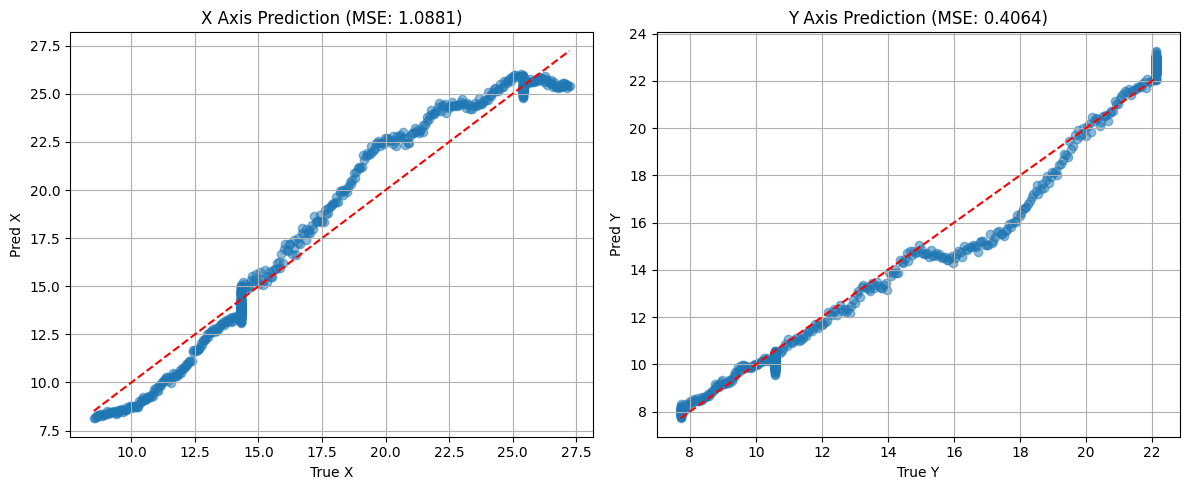

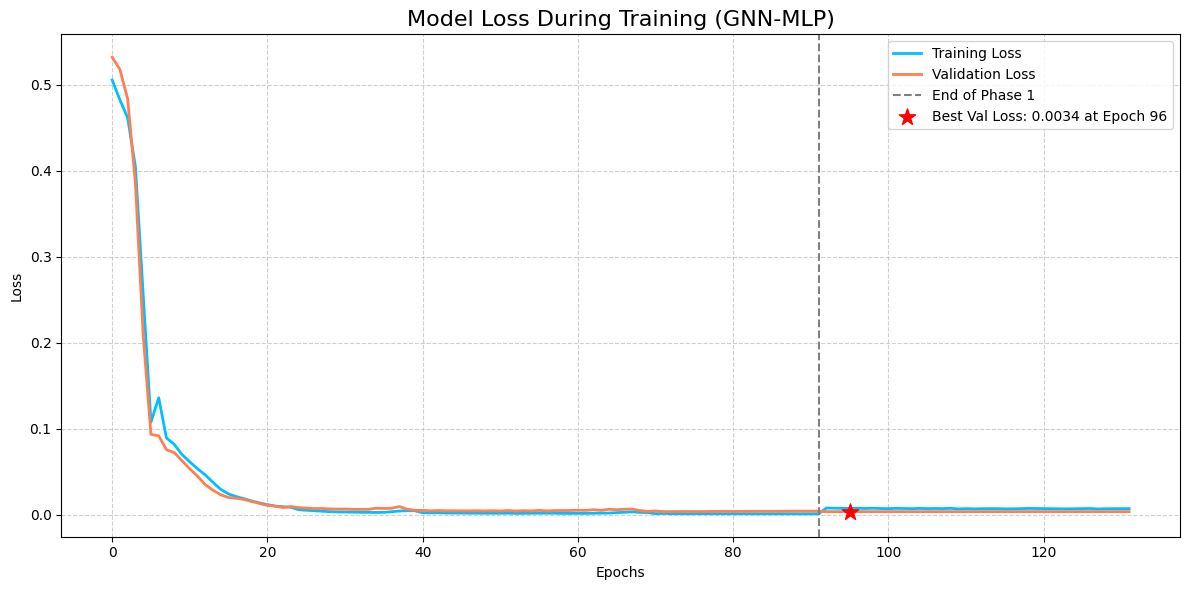

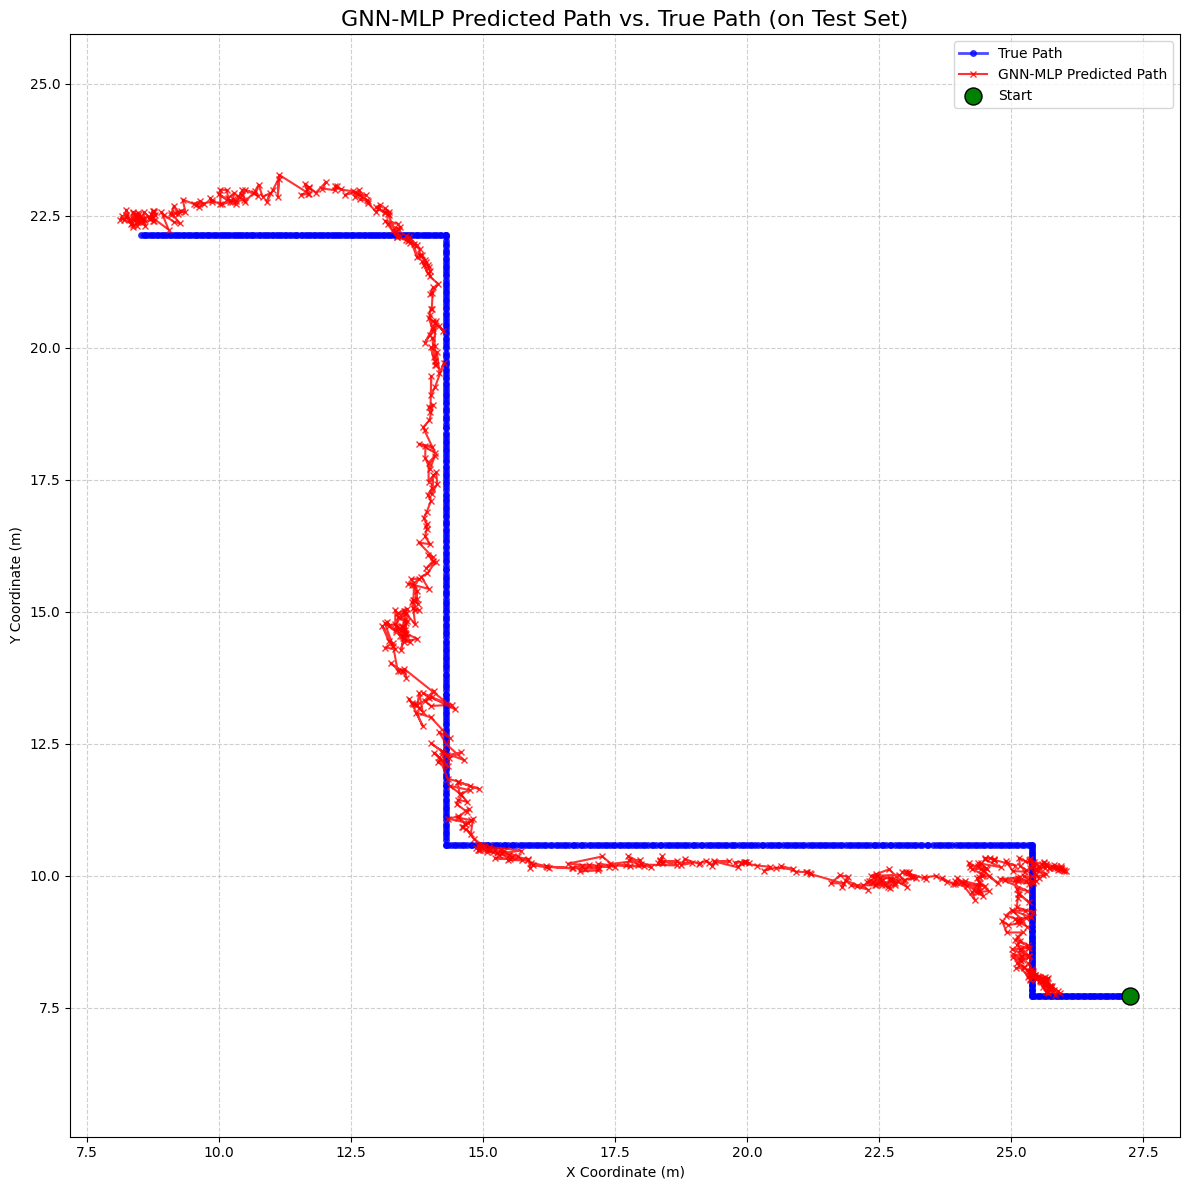

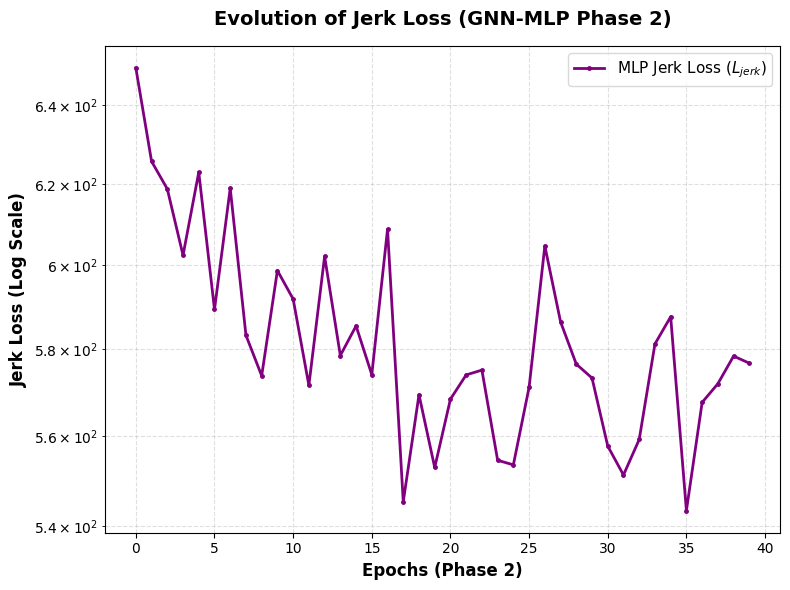

MLP 模型的 Jerk Loss 数据已保存为 'loss_data_MLP.npy'


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, HeteroConv
import sys 

# ==============================================================================
#                 【A. 依赖的模块、类和函数】
# ==============================================================================

# 0. 路径设置
try:
    current_dir = os.getcwd() 
    parent_dir = os.path.dirname(current_dir)
    if parent_dir not in sys.path:
        sys.path.append(parent_dir)
except Exception as e:
    print(f"添加 sys.path 失败: {e}")

# 1. 导入
try:
    from loss_function.custom_lossess_v4 import jerk_smoothness_loss_v2, velocity_heading_consistency_loss_v2
    print("成功导入自定义损失函数！")
except ImportError as e:
    print(f"【警告】无法导入本地模块: {e}")

# 2. GNNEncoder
class GNNEncoder(nn.Module):
    def __init__(self, wifi_input_dim, imu_input_dim, hidden_dim, windows_size, num_layers=2, heads=4, dropout=0.2):
        super().__init__()
        self.wifi_proj = nn.Linear(wifi_input_dim, hidden_dim)
        self.imu_proj = nn.Linear(imu_input_dim, hidden_dim)
        self.positional_embeddings = nn.Embedding(windows_size + 10, hidden_dim)
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()

        for _ in range(num_layers):
            conv = HeteroConv({
                ('wifi', 'temporal', 'wifi'): GATv2Conv(-1, hidden_dim // heads, heads=heads, dropout=dropout, add_self_loops=False, edge_dim=1),
                ('imu', 'temporal', 'imu'): GATv2Conv(-1, hidden_dim // heads, heads=heads, dropout=dropout, add_self_loops=False, edge_dim=1),
                ('imu', 'fuses', 'wifi'): GATv2Conv((-1, -1), hidden_dim // heads, heads=heads, dropout=dropout, add_self_loops=False, edge_dim=2),
                ('wifi', 'fuses', 'imu'): GATv2Conv((-1, -1), hidden_dim // heads, heads=heads, dropout=dropout, add_self_loops=False, edge_dim=1),
            }, aggr='sum')
            self.convs.append(conv)
            self.norms.append(nn.ModuleDict({
                'wifi': nn.LayerNorm(hidden_dim),
                'imu': nn.LayerNorm(hidden_dim),
            }))
        self.dropout_p = dropout

    def forward(self, data):
        x_dict, edge_index_dict, edge_attr_dict = data.x_dict, data.edge_index_dict, data.edge_attr_dict
        x_dict['wifi'] = self.wifi_proj(x_dict['wifi'])
        x_dict['imu'] = self.imu_proj(x_dict['imu'])
        x_dict['wifi'] = x_dict['wifi'] + self.positional_embeddings(data['wifi'].time_step)
        x_dict['imu'] = x_dict['imu'] + self.positional_embeddings(data['imu'].time_step)

        for i in range(len(self.convs)):
            residual_dict = {key: x.clone() for key, x in x_dict.items()}
            x_dict_after_conv = self.convs[i](x_dict, edge_index_dict, edge_attr_dict)
            for node_type, x in x_dict_after_conv.items():
                x_processed = F.
                (x)
                x_processed = F.dropout(x_processed, p=self.dropout_p, training=self.training)
                x_dict[node_type] = self.norms[i][node_type](x_processed + residual_dict[node_type])
        return x_dict

# 3. MLP 预测器 (消融实验用)
class MLPPredictor(nn.Module):
    def __init__(self, layers_hidden, use_lstm=True, lstm_hidden=32, dropout_rate=0.1):
        super().__init__()
        self.use_lstm = use_lstm
        mlp_input_dim = layers_hidden[0]
        if use_lstm:
            self.lstm = nn.LSTM(input_size=layers_hidden[0], hidden_size=lstm_hidden, num_layers=1, batch_first=True)
            mlp_input_dim = lstm_hidden
        else:
            self.lstm = None
        self.dropout = nn.Dropout(dropout_rate)
        layers = []
        current_dim = mlp_input_dim
        for hidden_dim in layers_hidden[1:-1]:
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_dim = hidden_dim
        layers.append(nn.Linear(current_dim, layers_hidden[-1]))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_lstm:
            lstm_out, _ = self.lstm(x) 
            output = self.mlp(lstm_out) 
        else:
            output = self.mlp(x) 
        return output

    def regularization_loss(self):
        return torch.tensor(0.0, device=self.mlp[0].weight.device if len(self.mlp)>0 else torch.device('cpu'))

# 4. 图构建函数 (保持不变)
def create_asymmetric_fuses_edges(window_size, past_radius, future_radius, device):
    causal_src_nodes, causal_dst_nodes = [], []
    for i in range(window_size):  
        start = max(0, i - past_radius)
        end = i + 1
        for j in range(start, end):  
            causal_src_nodes.append(j)
            causal_dst_nodes.append(i)
    edge_index_IMU_to_WiFi = torch.stack([
        torch.tensor(causal_src_nodes, dtype=torch.long, device=device),
        torch.tensor(causal_dst_nodes, dtype=torch.long, device=device)
    ], dim=0)

    future_src_nodes, future_dst_nodes = [], []
    for i in range(window_size):  
        start = i
        end = min(window_size, i + future_radius + 1)
        for j in range(start, end):  
            future_src_nodes.append(j)
            future_dst_nodes.append(i)
    edge_index_WiFi_to_IMU = torch.stack([
        torch.tensor(future_src_nodes, dtype=torch.long, device=device),
        torch.tensor(future_dst_nodes, dtype=torch.long, device=device)
    ], dim=0)
    return edge_index_IMU_to_WiFi, edge_index_WiFi_to_IMU

def create_temporal_edges_with_attr(node_features, device):
    num_nodes = node_features.size(0)
    if num_nodes < 2:
        return torch.empty((2, 0), dtype=torch.long, device=device), torch.empty((0, 1), dtype=torch.float, device=device)
    source_nodes = torch.arange(0, num_nodes - 1, device=device)
    dest_nodes = torch.arange(1, num_nodes, device=device)
    edge_index = torch.stack([source_nodes, dest_nodes], dim=0)
    feature_diff = node_features[1:] - node_features[:-1]
    edge_attr = torch.linalg.norm(feature_diff, dim=1).view(-1, 1)
    return edge_index, edge_attr

def create_graph_list_from_df(df, wifi_cols, imu_cols, windows_size, future_steps, device, past_radius, future_radius):
    graph_list = []
    num_samples = len(df) - windows_size - future_steps + 1
    accel_cols = [col for col in imu_cols if 'accelerometer' in col]
    gyro_cols = [col for col in imu_cols if 'gyroscope' in col]
    rss_cols = [col for col in wifi_cols if 'RSSI' in col]

    for i in range(num_samples):
        window_df = df.iloc[i : i + windows_size]
        future_df = df.iloc[i + windows_size : i + windows_size + future_steps]
        data = HeteroData()
        data['wifi'].x = torch.tensor(window_df[wifi_cols].values, dtype=torch.float, device=device)
        data['imu'].x = torch.tensor(window_df[imu_cols].values, dtype=torch.float, device=device)
        data['wifi'].time_step = torch.arange(windows_size, device=device)
        data['imu'].time_step = torch.arange(windows_size, device=device)

        wifi_edge_index, wifi_edge_attr = create_temporal_edges_with_attr(data['wifi'].x, device)
        imu_edge_index, imu_edge_attr = create_temporal_edges_with_attr(data['imu'].x, device)
        data[('wifi', 'temporal', 'wifi')].edge_index = wifi_edge_index
        data[('imu', 'temporal', 'imu')].edge_index = imu_edge_index
        data[('wifi', 'temporal', 'wifi')].edge_attr = wifi_edge_attr
        data[('imu', 'temporal', 'imu')].edge_attr = imu_edge_attr

        edge_index_IMU_to_WiFi, edge_index_WiFi_to_IMU = create_asymmetric_fuses_edges(windows_size, past_radius, future_radius, device)
        data[('imu', 'fuses', 'wifi')].edge_index = edge_index_IMU_to_WiFi
        data[('wifi', 'fuses', 'imu')].edge_index = edge_index_WiFi_to_IMU
        
        forward_src_indices = edge_index_IMU_to_WiFi[0] 
        motion_intensity = np.linalg.norm(window_df[accel_cols].values, axis=1)
        motion_intensity_tensor = torch.tensor(motion_intensity, dtype=torch.float, device=device)
        rotation_intensity = np.linalg.norm(window_df[gyro_cols].values, axis=1)
        rotation_intensity_tensor = torch.tensor(rotation_intensity, dtype=torch.float, device=device)
        fuses_edge_attr_forward = torch.cat([motion_intensity_tensor[forward_src_indices].view(-1, 1), rotation_intensity_tensor[forward_src_indices].view(-1, 1)], dim=1)
        data[('imu', 'fuses', 'wifi')].edge_attr = fuses_edge_attr_forward

        backward_src_indices = edge_index_WiFi_to_IMU[0]
        avg_rssi_per_node = window_df[rss_cols].mean(axis=1).values
        avg_rssi_tensor = torch.tensor(avg_rssi_per_node, dtype=torch.float, device=device)
        fuses_edge_attr_backward = avg_rssi_tensor[backward_src_indices].view(-1, 1)
        data[('wifi', 'fuses', 'imu')].edge_attr = fuses_edge_attr_backward

        labels = future_df[['x_coord', 'y_coord']].values
        data.y = torch.tensor(labels, dtype=torch.float, device=device)
        graph_list.append(data)
    return graph_list

# 5. GNN 包装器
class Attention(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.query_layer = nn.Linear(in_features, 1)
    def forward(self, x):
        weights = self.query_layer(x)
        scores = F.softmax(weights, dim=1)
        weighted_sum = torch.sum(x * scores, dim=1)
        return weighted_sum, scores

class GNN_LSTKAN_with_Attention_V2(nn.Module):
    def __init__(self, gnn_encoder, kan_predictor, future_steps):
        super().__init__()
        self.gnn_encoder = gnn_encoder
        self.kan_predictor = kan_predictor 
        self.future_steps = future_steps
        predictor_output_dim = None
        if hasattr(kan_predictor, 'mlp'):
            predictor_output_dim = kan_predictor.mlp[-1].out_features
        elif hasattr(kan_predictor, 'kan_layers'):
            try:
                predictor_output_dim = kan_predictor.kan_layers[-1].out_features
            except:
                 raise AttributeError(f"无法从 KAN 实例中提取输出维度。")
        else:
            raise TypeError(f"未知的预测器类型: {type(kan_predictor)}")
        if predictor_output_dim != (future_steps * 2):
            print(f"【警告】预测器输出维度 ({predictor_output_dim}) 与 future_steps*2 ({future_steps*2}) 不匹配。")
        self.attention = Attention(predictor_output_dim)

    def forward(self, data):
        x_dict = self.gnn_encoder(data)
        batch_size = data.num_graphs
        num_wifi_nodes = x_dict['wifi'].shape[0]
        window_size = num_wifi_nodes // batch_size
        hidden_dim = x_dict['wifi'].shape[1]
        x_wifi = x_dict['wifi'].view(batch_size, window_size, hidden_dim)
        if 'imu' in x_dict and x_dict['imu'].shape[0] > 0:
            x_imu = x_dict['imu'].view(batch_size, window_size, hidden_dim)
            x_combined = (x_wifi + x_imu) / 2.0
        else:
            x_combined = x_wifi
        raw_output = self.kan_predictor(x_combined)
        final_prediction, _ = self.attention(raw_output)
        main_pred = final_prediction.view(batch_size, self.future_steps, 2)
        return main_pred, None, None

    def regularization_loss(self):
        if hasattr(self.kan_predictor, 'regularization_loss'):
            return self.kan_predictor.regularization_loss()
        return torch.tensor(0.0, device=next(self.parameters()).device)

# ==============================================================================
#                       【B. 主执行逻辑】
# ==============================================================================

# 训练函数 Phase 1
def train_phase_1(model, train_loader, val_loader, initial_lr, weight_decay, num_epochs, patience, kan_reg_weight, lambda_vel, model_save_path):
    print("\n" + "="*80)
    print("--- 开始第一阶段：基础模型训练 (GNN-MLP) ---")
    print("="*80)
    device = next(model.parameters()).device
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in tqdm(range(num_epochs), desc="Phase 1 Epochs"):
        model.train()
        epoch_train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            main_pred, _, _ = model(batch)
            true_seq = batch.y.view(batch.num_graphs, -1, 2)
            loss_coord = criterion(main_pred, true_seq)
            pred_vel = (main_pred[:, 1:] - main_pred[:, :-1])
            true_vel = (true_seq[:, 1:] - true_seq[:, :-1])
            loss_vel = criterion(pred_vel, true_vel) if pred_vel.shape[1] > 0 else 0
            base_loss = loss_coord + lambda_vel * loss_vel
            reg_loss = model.regularization_loss()
            total_loss = base_loss + kan_reg_weight * reg_loss
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_train_loss += total_loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred_seq, _, _ = model(batch)
                true_seq = batch.y.view(batch.num_graphs, -1, 2)
                loss_coord_val = criterion(pred_seq, true_seq)
                pred_vel_val = (pred_seq[:, 1:] - pred_seq[:, :-1])
                true_vel_val = (true_seq[:, 1:] - true_seq[:, :-1])
                loss_vel_val = criterion(pred_vel_val, true_vel_val) if pred_vel_val.shape[1] > 0 else 0
                val_loss = loss_coord_val + lambda_vel * loss_vel_val
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"\n第一阶段早停于 Epoch {epoch + 1}")
            break
            
    print(f"--- 第一阶段训练完成 ---")
    return train_losses, val_losses

# ------------------------------------------------------------------------------
# 【核心修改】训练函数 Phase 2: 增加 Jerk Loss 记录
# ------------------------------------------------------------------------------
def train_phase_2_finetune(pretrained_model_path, model, train_loader, val_loader, finetune_lr, weight_decay, num_epochs, patience, kan_reg_weight, lambda_vel, smooth_weight, consistency_weight, finetuned_model_save_path):
    print("\n" + "="*80)
    print("--- 开始第二阶段：物理精调 (GNN-MLP) ---")
    print("="*80)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"正在加载第一阶段的最佳模型: {pretrained_model_path}")
    model.load_state_dict(torch.load(pretrained_model_path, weights_only=False)) 
    model.to(device)

    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=finetune_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
    best_val_loss = float('inf')
    patience_counter = 0
    
    train_losses, val_losses = [], []
    train_jerk_losses = [] # <--- 1. 新增列表

    epoch_progress = tqdm(range(num_epochs), desc="Phase 2 Epochs")
    for epoch in epoch_progress:
        model.train()
        epoch_train_loss = 0
        epoch_jerk_loss = 0 # <--- 2. 新增累加器
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            main_pred, _, _ = model(batch)
            true_seq = batch.y.view(batch.num_graphs, -1, 2)
            
            loss_coord = criterion(main_pred, true_seq)
            pred_vel = (main_pred[:, 1:] - main_pred[:, :-1])
            true_vel = (true_seq[:, 1:] - true_seq[:, :-1])
            loss_vel = criterion(pred_vel, true_vel) if pred_vel.shape[1] > 0 else 0
            base_loss = loss_coord + lambda_vel * loss_vel
            
            smooth_loss = jerk_smoothness_loss_v2(main_pred)
            consistency_loss = velocity_heading_consistency_loss_v2(main_pred)

            total_loss = (base_loss + smooth_weight * smooth_loss + consistency_weight * consistency_loss)

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_train_loss += total_loss.item()
            epoch_jerk_loss += smooth_loss.item() # <--- 3. 记录 Jerk Loss
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # <--- 4. 计算平均 Jerk Loss 并保存
        avg_jerk_loss = epoch_jerk_loss / len(train_loader)
        train_jerk_losses.append(avg_jerk_loss)
        
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred_seq, _, _ = model(batch)
                true_seq = batch.y.view(batch.num_graphs, -1, 2)
                loss_coord_val = criterion(pred_seq, true_seq)
                pred_vel_val = (pred_seq[:, 1:] - pred_seq[:, :-1])
                true_vel_val = (true_seq[:, 1:] - true_seq[:, :-1])
                loss_vel_val = criterion(pred_vel_val, true_vel_val) if pred_vel_val.shape[1] > 0 else 0
                val_loss = loss_coord_val + lambda_vel * loss_vel_val
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        epoch_progress.set_postfix(
            TrainLoss=f'{avg_train_loss:.4f}', 
            ValLoss=f'{avg_val_loss:.4f}', 
            JerkL=f'{avg_jerk_loss:.4f}' # 在进度条显示
        )

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), finetuned_model_save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"\n第二阶段早停于 Epoch {epoch + 1}")
            break

    print(f"--- 第二阶段精调完成 ---")
    # <--- 5. 返回 Jerk Loss 列表
    return train_losses, val_losses, train_jerk_losses

# ------------------------------------------------------------------------------
# 主函数
# ------------------------------------------------------------------------------
if __name__ == "__main__":
    
    # 1. 准备数据
    print("--- 阶段 0: 数据准备 ---")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    filesname = "MLP_FULL_Graph_Zoulang.csv"

    train_data = pd.read_csv(r'../Datasets/Zoulang/train.csv')
    val_data = pd.read_csv(r'../Datasets/Zoulang/validation.csv')
    test_data = pd.read_csv(r'../Datasets/Zoulang/test.csv')

    print("\nData loaded successfully!")
    print(f"Training data shape:   {train_data.shape}")
    
    column_names = train_data.drop(['timestamp','x_coord', 'y_coord'], axis=1).columns.tolist()
    coord_cols = ['x_coord', 'y_coord']
    wifi_features = [col for col in column_names if any(sensor in col for sensor in ["RSSI","distance"])]
    imu_features = [col for col in column_names if any(sensor in col for sensor in ["accelerometer", "gyroscope","magnetometer"])]
    
    scaler_wifi = StandardScaler().fit(train_data[wifi_features])
    scaler_imu = StandardScaler().fit(train_data[imu_features])
    scaler_coords = StandardScaler().fit(train_data[coord_cols])

    train_df_scaled = train_data.copy()
    val_df_scaled = val_data.copy()
    test_df_scaled = test_data.copy()

    for df in [train_df_scaled, val_df_scaled, test_df_scaled]:
        df[wifi_features] = scaler_wifi.transform(df[wifi_features])
        df[imu_features] = scaler_imu.transform(df[imu_features])
        df[coord_cols] = scaler_coords.transform(df[coord_cols])

    windows_size = 80
    future_steps = 5
    future_radius = 10
    past_radius = 15 

    print("正在从DataFrame创建异构图数据列表...")
    train_data_list = create_graph_list_from_df(train_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu', past_radius, future_radius)
    val_data_list = create_graph_list_from_df(val_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu', past_radius, future_radius)
    test_data_list = create_graph_list_from_df(test_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu', past_radius, future_radius)

    batch_size = 128
    train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_data_list, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data_list, batch_size=batch_size, shuffle=False)

    # 2. 模型实例化 (MLP 消融)
    print("\n--- 阶段 1: 模型实例化 (消融试验: GNN-MLP) ---")
    wifi_feat_dim = len(wifi_features)
    imu_feat_dim = len(imu_features)
    gnn_hidden_dim = 32 
    output_dim = future_steps * 2 
    gnn_heads = 4
    dropout_p = 0.2 

    gnn_encoder_instance = GNNEncoder(
        wifi_input_dim=wifi_feat_dim,
        imu_input_dim=imu_feat_dim,
        hidden_dim=gnn_hidden_dim,
        windows_size=windows_size,
        num_layers=1,
        heads=gnn_heads,
        dropout=dropout_p
    ).to(device)

    mlp_layers_config = [gnn_hidden_dim, 64, output_dim]
    mlp_predictor_instance = MLPPredictor(
        layers_hidden=mlp_layers_config,
        use_lstm=True,
        lstm_hidden=32,
        dropout_rate=dropout_p,
    ).to(device)

    end_to_end_model = GNN_LSTKAN_with_Attention_V2(
        gnn_encoder=gnn_encoder_instance,
        kan_predictor=mlp_predictor_instance, # 传入 MLP
        future_steps=future_steps
    ).to(device)
    print("端到端模型实例化完成 (GNN-LSTM-MLP)。")

    # 3. 训练参数
    os.makedirs('Model', exist_ok=True)
    
    PHASE_1_LR = 2.7e-3
    PHASE_1_EPOCHS = 200
    PHASE_1_PATIENCE = 20
    
    PHASE_2_LR = 3.75e-5 
    PHASE_2_EPOCHS = 40
    PHASE_2_PATIENCE = 40
    
    WEIGHT_DECAY = 3.4e-5
    KAN_REG_WEIGHT = 4.1e-5 
    LAMBDA_VEL = 0.029
    SMOOTH_WEIGHT = 1e-5
    CONSISTENCY_WEIGHT = 3.3e-4

    # 4. 执行训练
    phase1_model_path = 'Model/phase1_best_model_GMLP.pth'
    p1_train_losses, p1_val_losses = train_phase_1(
        model=end_to_end_model,
        train_loader=train_loader,
        val_loader=val_loader,
        initial_lr=PHASE_1_LR,
        weight_decay=WEIGHT_DECAY,
        num_epochs=PHASE_1_EPOCHS,
        patience=PHASE_1_PATIENCE,
        kan_reg_weight=KAN_REG_WEIGHT,
        lambda_vel=LAMBDA_VEL,
        model_save_path=phase1_model_path
    )
    
    phase2_model_path = 'Model/phase2_finetuned_best_model_GMLP.pth'
    
    # <--- 【修改】接收 Jerk Losses
    p2_train_losses, p2_val_losses, p2_jerk_losses = train_phase_2_finetune(
        pretrained_model_path=phase1_model_path,
        model=end_to_end_model,
        train_loader=train_loader,
        val_loader=val_loader,
        finetune_lr=PHASE_2_LR,
        weight_decay=WEIGHT_DECAY,
        num_epochs=PHASE_2_EPOCHS,
        patience=PHASE_2_PATIENCE,
        kan_reg_weight=KAN_REG_WEIGHT,
        lambda_vel=LAMBDA_VEL,
        smooth_weight=SMOOTH_WEIGHT,
        consistency_weight=CONSISTENCY_WEIGHT,
        finetuned_model_save_path=phase2_model_path
    )
    
    train_losses = p1_train_losses + p2_train_losses
    val_losses = p1_val_losses + p2_val_losses

    # 5. 测试
    print("\n--- 最终测试: 加载精调后的最佳模型 ---")
    end_to_end_model.load_state_dict(torch.load(phase2_model_path, weights_only=False)) 
    
    end_to_end_model.eval()
    test_loss = 0
    pred_coords_list = []
    true_coords_list = []
    criterion = nn.HuberLoss()

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            batch = batch.to(device)
            pred_seq,_,_ = end_to_end_model(batch)
            true_seq = batch.y.view(batch.num_graphs, -1, 2)
            loss_coord_test = criterion(pred_seq, true_seq)
            pred_vel_test = (pred_seq[:, 1:] - pred_seq[:, :-1])
            true_vel_test = (true_seq[:, 1:] - true_seq[:, :-1])
            loss_vel_test = criterion(pred_vel_test, true_vel_test) if pred_vel_test.shape[1] > 0 else 0
            loss = loss_coord_test + LAMBDA_VEL * loss_vel_test
            test_loss += loss.item()
            pred_last_step = pred_seq[:, -1, :].cpu().numpy()
            true_last_step = true_seq[:, -1, :].cpu().numpy()
            pred_coords_list.append(pred_last_step)
            true_coords_list.append(true_last_step)

    avg_test_loss = test_loss / len(test_loader)
    print(f'Test Loss: {avg_test_loss:.4f}')

    pred_coords = np.concatenate(pred_coords_list, axis=0)
    true_coords = np.concatenate(true_coords_list, axis=0)
    pred_coords_orig = scaler_coords.inverse_transform(pred_coords)
    true_coords_orig = scaler_coords.inverse_transform(true_coords)
    
    # 6. 保存结果
    result_test_df = pd.DataFrame({
        'Pred_X': pred_coords_orig[:, 0],
        'Pred_Y': pred_coords_orig[:, 1],
        'True_X': true_coords_orig[:, 0],
        'True_Y': true_coords_orig[:, 1],
    })
    os.makedirs('results', exist_ok=True)
    result_filename = f'results/GMLP_full_graph_{filesname}'
    result_test_df.to_csv(result_filename, index=False)
    print(f"Test results saved to '{result_filename}'")

    mse_x = np.mean((true_coords_orig[:, 0] - pred_coords_orig[:, 0])** 2)
    mse_y = np.mean((true_coords_orig[:, 1] - pred_coords_orig[:, 1])** 2)
    rmse_total = np.sqrt(np.mean((true_coords_orig - pred_coords_orig)** 2))
    ade = np.mean(np.sqrt(np.sum((true_coords_orig - pred_coords_orig)**2, axis=1)))

    print("\n--- 模型评估结果 (GNN-MLP 完整图) ---")
    print(f"X轴均方误差 (MSE X): {mse_x:.4f} (米^2)")
    print(f"Y轴均方误差 (MSE Y): {mse_y:.4f} (米^2)")
    print(f"总均方根误差 (RMSE): {rmse_total:.4f} (米)")
    print(f"平均位移误差 (ADE/FDE): {ade:.4f} (米)")
    print("--------------------")

    os.makedirs('Picture', exist_ok=True)
    
    # 散点图
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(true_coords_orig[:, 0], pred_coords_orig[:, 0], alpha=0.5)
    plt.plot([true_coords_orig[:, 0].min(), true_coords_orig[:, 0].max()], [true_coords_orig[:, 0].min(), true_coords_orig[:, 0].max()], 'r--')
    plt.xlabel('True X'); plt.ylabel('Pred X'); plt.title(f'X Axis Prediction (MSE: {mse_x:.4f})'); plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.scatter(true_coords_orig[:, 1], pred_coords_orig[:, 1], alpha=0.5)
    plt.plot([true_coords_orig[:, 1].min(), true_coords_orig[:, 1].max()], [true_coords_orig[:, 1].min(), true_coords_orig[:, 1].max()], 'r--')
    plt.xlabel('True Y'); plt.ylabel('Pred Y'); plt.title(f'Y Axis Prediction (MSE: {mse_y:.4f})'); plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 损失曲线图
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss', color='deepskyblue', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', color='coral', linewidth=2)
    plt.axvline(x=len(p1_val_losses)-1, color='grey', linestyle='--', label='End of Phase 1')
    best_val_epoch = np.argmin(val_losses)
    best_val_score = val_losses[best_val_epoch]
    plt.scatter(best_val_epoch, best_val_score, marker='*', color='red', s=150, zorder=5, label=f'Best Val Loss: {best_val_score:.4f} at Epoch {best_val_epoch+1}')
    plt.title('Model Loss During Training (GNN-MLP)', fontsize=16)
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    # 轨迹对比图
    plt.figure(figsize=(12, 12))
    plt.plot(true_coords_orig[:, 0], true_coords_orig[:, 1], 'o-', label='True Path', color='blue', linewidth=2, markersize=4, alpha=0.7)
    plt.plot(pred_coords_orig[:, 0], pred_coords_orig[:, 1], 'x-', label='GNN-MLP Predicted Path', color='red', linewidth=1.5, markersize=4, alpha=0.8)
    if len(true_coords_orig) > 0:
        plt.scatter(true_coords_orig[0, 0], true_coords_orig[0, 1], s=150, c='green', marker='o', edgecolors='black', label='Start', zorder=5)
    plt.title('GNN-MLP Predicted Path vs. True Path (on Test Set)', fontsize=16)
    plt.xlabel('X Coordinate (m)'); plt.ylabel('Y Coordinate (m)'); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # =================================================================
    #               【核心新增】绘制 Jerk Loss 曲线 (MLP版)
    # =================================================================
    plt.figure(figsize=(8, 6))
    
    # 给 Loss 加一个极小值 eps，防止 log(0) 报错
    eps = 1e-8
    losses_to_plot = np.array(p2_jerk_losses) + eps

    # 绘制曲线
    plt.plot(losses_to_plot, label='MLP Jerk Loss ($L_{jerk}$)', color='#800080', linewidth=2, marker='.', markersize=5)
    
    # 设置对数坐标轴
    plt.yscale('log')
    
    # 样式美化
    plt.title('Evolution of Jerk Loss (GNN-MLP Phase 2)', fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Epochs (Phase 2)', fontsize=12, fontweight='bold')
    plt.ylabel('Jerk Loss (Log Scale)', fontsize=12, fontweight='bold')
    
    plt.grid(True, which="both", ls="--", alpha=0.4)
    plt.legend(fontsize=11, frameon=True, edgecolor='#D0D0D0')
    
    plt.tight_layout()
    plt.show()

        # 将列表转换为 numpy 数组并保存
    np.save('loss_data_MLP.npy', p2_jerk_losses) 
    print("MLP 模型的 Jerk Loss 数据已保存为 'loss_data_MLP.npy'")

成功加载数据: KAN (40 epochs), MLP (40 epochs)


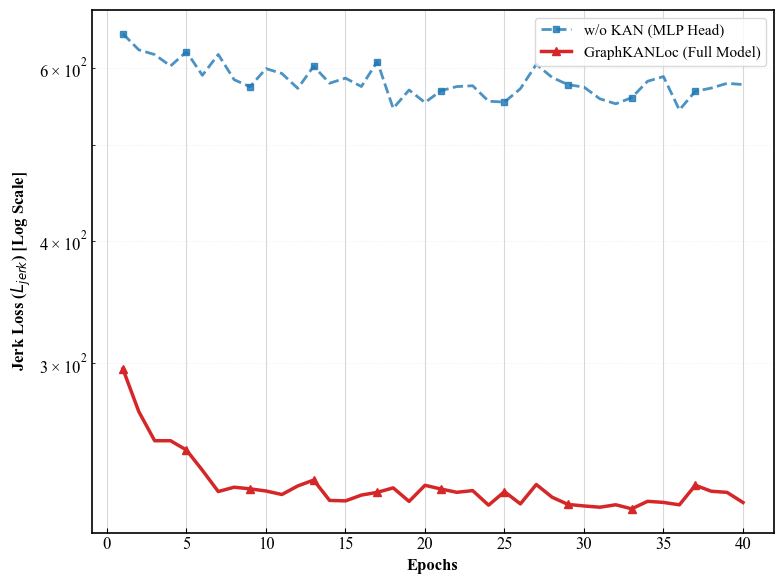

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. 设置 Nature 期刊风格
# ==========================================
plt.rcParams['font.family'] = 'Times new Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# ==========================================
# 2. 加载数据
# ==========================================
try:
    loss_kan = np.load('../loss_data_KAN.npy')
    loss_mlp = np.load('loss_data_MLP.npy')
    print(f"成功加载数据: KAN ({len(loss_kan)} epochs), MLP ({len(loss_mlp)} epochs)")
except FileNotFoundError:
    print("错误: 找不到 .npy 数据文件。")
    # 生成不同长度的假数据演示效果
    loss_kan = 10**(-np.linspace(1, 8, 200)) # 假设 KAN 跑了 200 轮
    loss_mlp = 10**(-np.linspace(1, 5, 100)) # 假设 MLP 只跑了 100 轮

# 【核心修改 1】不再计算 min_len，而是分别生成 X 轴坐标
epochs_kan = np.arange(1, len(loss_kan) + 1)
epochs_mlp = np.arange(1, len(loss_mlp) + 1)

# 防止 log(0) 报错
eps = 1e-10
loss_kan = loss_kan + eps
loss_mlp = loss_mlp + eps

# ==========================================
# 3. 绘制对比图
# ==========================================
plt.figure(figsize=(8, 6))

# 绘制 MLP (可能较短)
# 【核心修改 2】x 轴使用 epochs_mlp，y 轴使用原始 loss_mlp
plt.plot(epochs_mlp, loss_mlp, 
         label='w/o KAN (MLP Head)', 
         color='#1F77B4', 
         linestyle='--', 
         linewidth=2, 
         marker='s', 
         markersize=5,
         # 标记密度根据自身长度动态调整，防止太密
         markevery=max(1, len(loss_mlp)//10), 
         alpha=0.8)

# 绘制 KAN (可能较长)
# 【核心修改 3】x 轴使用 epochs_kan，y 轴使用原始 loss_kan
plt.plot(epochs_kan, loss_kan, 
         label='GraphKANLoc (Full Model)', 
         color='#D62728', 
         linestyle='-', 
         linewidth=2.5, 
         marker='^', 
         markersize=6,
         markevery=max(1, len(loss_kan)//10),
         alpha=1.0)

# ==========================================
# 4. 细节美化
# ==========================================
plt.yscale('log')

# plt.title('Ablation Study: Jerk Loss Convergence', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Jerk Loss ($L_{jerk}$) [Log Scale]', fontsize=12, fontweight='bold')

plt.grid(True, which="major", linestyle='-', alpha=0.3, color='gray')
plt.grid(True, which="minor", linestyle=':', alpha=0.1, color='gray')

plt.legend(fontsize=11, frameon=True, edgecolor='#D0D0D0', loc='upper right')

plt.tight_layout()
plt.savefig('Ablation_Jerk_Loss_Comparison_Full.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, HeteroConv
import sys

# ==============================================================================
#                   【A. 依赖的模块、类和函数】
# ==============================================================================

# ------------------------------------------------------------------------------
# 0. 路径设置
# ------------------------------------------------------------------------------
try:
    current_dir = os.getcwd() 
    parent_dir = os.path.dirname(current_dir)
    if parent_dir not in sys.path:
        sys.path.append(parent_dir)
    # print(f"已将 {parent_dir} 添加到 sys.path")
except Exception as e:
    print(f"添加 sys.path 失败: {e}")

# ------------------------------------------------------------------------------
# 1. 导入本地模块 (保持您原有的导入)
# ------------------------------------------------------------------------------
try:
    # 假设您的环境中有这些文件，如果报错请检查路径
    # from kan_improved import KAN 
    from loss_function.custom_lossess_v4 import jerk_smoothness_loss_v2, velocity_heading_consistency_loss_v2
    print("成功导入自定义损失函数！")
except ImportError as e:
    print(f"【注意】无法导入本地模块 (可能是路径问题): {e}")
    # 为了保证代码在没有这些文件时也能跑通 (仅做演示)，定义假的 loss 函数
    # 如果您有文件，请忽略这里
    def jerk_smoothness_loss_v2(x): return 0.0
    def velocity_heading_consistency_loss_v2(x): return 0.0

# ------------------------------------------------------------------------------
# 2. GNNEncoder
# ------------------------------------------------------------------------------
class GNNEncoder(nn.Module):
    def __init__(self, wifi_input_dim, imu_input_dim, hidden_dim, windows_size, num_layers=2, heads=4, dropout=0.2):
        super().__init__()
        self.wifi_proj = nn.Linear(wifi_input_dim, hidden_dim)
        self.imu_proj = nn.Linear(imu_input_dim, hidden_dim)
        self.positional_embeddings = nn.Embedding(windows_size + 10, hidden_dim)
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()

        for _ in range(num_layers):
            conv = HeteroConv({
                ('wifi', 'temporal', 'wifi'): GATv2Conv(-1, hidden_dim // heads, heads=heads, dropout=dropout, add_self_loops=False, edge_dim=1),
                ('imu', 'temporal', 'imu'): GATv2Conv(-1, hidden_dim // heads, heads=heads, dropout=dropout, add_self_loops=False, edge_dim=1),
                ('imu', 'fuses', 'wifi'): GATv2Conv((-1, -1), hidden_dim // heads, heads=heads, dropout=dropout, add_self_loops=False, edge_dim=2),
                ('wifi', 'fuses', 'imu'): GATv2Conv((-1, -1), hidden_dim // heads, heads=heads, dropout=dropout, add_self_loops=False, edge_dim=1),
            }, aggr='sum')
            self.convs.append(conv)
            self.norms.append(nn.ModuleDict({
                'wifi': nn.LayerNorm(hidden_dim),
                'imu': nn.LayerNorm(hidden_dim),
            }))
        
        self.dropout_p = dropout

    def forward(self, data):
        x_dict, edge_index_dict, edge_attr_dict = data.x_dict, data.edge_index_dict, data.edge_attr_dict

        x_dict['wifi'] = self.wifi_proj(x_dict['wifi'])
        x_dict['imu'] = self.imu_proj(x_dict['imu'])
        x_dict['wifi'] = x_dict['wifi'] + self.positional_embeddings(data['wifi'].time_step)
        x_dict['imu'] = x_dict['imu'] + self.positional_embeddings(data['imu'].time_step)

        for i in range(len(self.convs)):
            residual_dict = {key: x.clone() for key, x in x_dict.items()}
            x_dict_after_conv = self.convs[i](x_dict, edge_index_dict, edge_attr_dict)
            for node_type, x in x_dict_after_conv.items():
                x_processed = F.silu(x)
                x_processed = F.dropout(x_processed, p=self.dropout_p, training=self.training)
                x_dict[node_type] = self.norms[i][node_type](x_processed + residual_dict[node_type])
        
        return x_dict

# ------------------------------------------------------------------------------
# 3. MLPPredictor
# ------------------------------------------------------------------------------
class MLPPredictor(nn.Module):
    def __init__(self, layers_hidden, use_lstm=True, lstm_hidden=32, dropout_rate=0.1):
        super().__init__()
        self.use_lstm = use_lstm
        mlp_input_dim = layers_hidden[0]
        if use_lstm:
            self.lstm = nn.LSTM(input_size=layers_hidden[0], hidden_size=lstm_hidden, num_layers=1, batch_first=True)
            mlp_input_dim = lstm_hidden
        else:
            self.lstm = None
        
        self.dropout = nn.Dropout(dropout_rate)
        layers = []
        current_dim = mlp_input_dim
        for hidden_dim in layers_hidden[1:-1]:
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.SiLU())  
            layers.append(nn.Dropout(dropout_rate))
            current_dim = hidden_dim
        layers.append(nn.Linear(current_dim, layers_hidden[-1]))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_lstm:
            lstm_out, _ = self.lstm(x) 
            output = self.mlp(lstm_out) 
            return output
        else:
            x_last = x[:, -1, :] 
            output_last = self.mlp(x_last) 
            window_size = x.shape[1]
            output_dim = output_last.shape[1]
            output = torch.zeros(x.shape[0], window_size, output_dim, device=x.device)
            output[:, -1, :] = output_last
            return output

    def regularization_loss(self):
        return torch.tensor(0.0)

# ------------------------------------------------------------------------------
# 4. 图构建函数
# ------------------------------------------------------------------------------
def create_asymmetric_fuses_edges(window_size, past_radius, future_radius, device):
    causal_src_nodes, causal_dst_nodes = [], []
    for i in range(window_size):  
        start = max(0, i - past_radius)
        end = i + 1
        for j in range(start, end):  
            causal_src_nodes.append(j)
            causal_dst_nodes.append(i)
    
    edge_index_IMU_to_WiFi = torch.stack([
        torch.tensor(causal_src_nodes, dtype=torch.long, device=device),
        torch.tensor(causal_dst_nodes, dtype=torch.long, device=device)
    ], dim=0)

    future_src_nodes, future_dst_nodes = [], []
    for i in range(window_size):  
        start = i
        end = min(window_size, i + future_radius + 1)
        for j in range(start, end):  
            future_src_nodes.append(j)
            future_dst_nodes.append(i)

    edge_index_WiFi_to_IMU = torch.stack([
        torch.tensor(future_src_nodes, dtype=torch.long, device=device),
        torch.tensor(future_dst_nodes, dtype=torch.long, device=device)
    ], dim=0)

    return edge_index_IMU_to_WiFi, edge_index_WiFi_to_IMU

def create_temporal_edges_with_attr(node_features, device):
    num_nodes = node_features.size(0)
    if num_nodes < 2:
        return torch.empty((2, 0), dtype=torch.long, device=device), \
               torch.empty((0, 1), dtype=torch.float, device=device)

    source_nodes = torch.arange(0, num_nodes - 1, device=device)
    dest_nodes = torch.arange(1, num_nodes, device=device)
    edge_index = torch.stack([source_nodes, dest_nodes], dim=0)
    
    feature_diff = node_features[1:] - node_features[:-1]
    edge_attr = torch.linalg.norm(feature_diff, dim=1).view(-1, 1)

    return edge_index, edge_attr

def create_graph_list_from_df(df, wifi_cols, imu_cols, windows_size, future_steps, device, past_radius, future_radius):
    graph_list = []
    num_samples = len(df) - windows_size - future_steps + 1

    accel_cols = [col for col in imu_cols if 'accelerometer' in col]
    gyro_cols = [col for col in imu_cols if 'gyroscope' in col]
    rss_cols = [col for col in wifi_cols if 'RSSI' in col]

    # 为了演示，如果找不到列，避免报错 (您可以根据实际数据调整)
    if not accel_cols: accel_cols = imu_cols[:3]
    if not gyro_cols: gyro_cols = imu_cols[3:6]
    if not rss_cols: rss_cols = wifi_cols

    for i in range(num_samples):
        window_df = df.iloc[i : i + windows_size]
        future_df = df.iloc[i + windows_size : i + windows_size + future_steps]
        
        data = HeteroData()
        
        data['wifi'].x = torch.tensor(window_df[wifi_cols].values, dtype=torch.float, device=device)
        data['imu'].x = torch.tensor(window_df[imu_cols].values, dtype=torch.float, device=device)
        
        data['wifi'].time_step = torch.arange(windows_size, device=device)
        data['imu'].time_step = torch.arange(windows_size, device=device)

        wifi_edge_index, wifi_edge_attr = create_temporal_edges_with_attr(data['wifi'].x, device)
        imu_edge_index, imu_edge_attr = create_temporal_edges_with_attr(data['imu'].x, device)
        data[('wifi', 'temporal', 'wifi')].edge_index = wifi_edge_index
        data[('imu', 'temporal', 'imu')].edge_index = imu_edge_index
        data[('wifi', 'temporal', 'wifi')].edge_attr = wifi_edge_attr
        data[('imu', 'temporal', 'imu')].edge_attr = imu_edge_attr

        edge_index_IMU_to_WiFi, edge_index_WiFi_to_IMU = create_asymmetric_fuses_edges(windows_size, past_radius, future_radius, device)
        
        data[('imu', 'fuses', 'wifi')].edge_index = edge_index_IMU_to_WiFi
        data[('wifi', 'fuses', 'imu')].edge_index = edge_index_WiFi_to_IMU
        
        # edge attr creation (simplified for robustness)
        try:
            forward_src_indices = edge_index_IMU_to_WiFi[0] 
            motion_intensity = np.linalg.norm(window_df[accel_cols].values, axis=1)
            rotation_intensity = np.linalg.norm(window_df[gyro_cols].values, axis=1)
            
            fuses_edge_attr_forward = torch.cat([
                torch.tensor(motion_intensity, dtype=torch.float, device=device)[forward_src_indices].view(-1, 1), 
                torch.tensor(rotation_intensity, dtype=torch.float, device=device)[forward_src_indices].view(-1, 1)
            ], dim=1)
            data[('imu', 'fuses', 'wifi')].edge_attr = fuses_edge_attr_forward

            backward_src_indices = edge_index_WiFi_to_IMU[0]
            avg_rssi_per_node = window_df[rss_cols].mean(axis=1).values
            fuses_edge_attr_backward = torch.tensor(avg_rssi_per_node, dtype=torch.float, device=device)[backward_src_indices].view(-1, 1)
            data[('wifi', 'fuses', 'imu')].edge_attr = fuses_edge_attr_backward
        except Exception:
             # Fallback if columns missing
             data[('imu', 'fuses', 'wifi')].edge_attr = torch.zeros((edge_index_IMU_to_WiFi.size(1), 2), device=device)
             data[('wifi', 'fuses', 'imu')].edge_attr = torch.zeros((edge_index_WiFi_to_IMU.size(1), 1), device=device)

        labels = future_df[['x_coord', 'y_coord']].values
        data.y = torch.tensor(labels, dtype=torch.float, device=device)
        
        graph_list.append(data)
        
    return graph_list

# ------------------------------------------------------------------------------
# 5. GNN 包装器
# ------------------------------------------------------------------------------
class Attention(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.query_layer = nn.Linear(in_features, 1)
    
    def forward(self, x):
        weights = self.query_layer(x)
        scores = F.softmax(weights, dim=1)
        weighted_sum = torch.sum(x * scores, dim=1)
        return weighted_sum, scores

class GNN_LSTKAN_with_Attention_V2(nn.Module):
    def __init__(self, gnn_encoder, kan_predictor, future_steps):
        super().__init__()
        self.gnn_encoder = gnn_encoder
        self.kan_predictor = kan_predictor
        self.future_steps = future_steps

        predictor_output_dim = None
        if hasattr(kan_predictor, 'mlp'):
            predictor_output_dim = kan_predictor.mlp[-1].out_features
        elif hasattr(kan_predictor, 'kan_layers'):
            predictor_output_dim = kan_predictor.kan_layers[-1].out_features
        else:
            # Fallback
            predictor_output_dim = future_steps * 2

        self.attention = Attention(predictor_output_dim)

    def forward(self, data):
        x_dict = self.gnn_encoder(data)
        batch_size = data.num_graphs
        num_wifi_nodes = x_dict['wifi'].shape[0]
        
        if batch_size > 0:
            window_size = num_wifi_nodes // batch_size
        else:
            window_size = 0
            
        hidden_dim = x_dict['wifi'].shape[1]
        
        x_wifi = x_dict['wifi'].view(batch_size, window_size, hidden_dim)
        if 'imu' in x_dict and x_dict['imu'].shape[0] > 0:
            x_imu = x_dict['imu'].view(batch_size, window_size, hidden_dim)
            x_combined = (x_wifi + x_imu) / 2.0
        else:
            x_combined = x_wifi
        
        raw_output = self.kan_predictor(x_combined)
        final_prediction, _ = self.attention(raw_output)
        main_pred = final_prediction.view(batch_size, self.future_steps, 2)
        
        return main_pred, None, None

    def regularization_loss(self):
        if hasattr(self.kan_predictor, 'regularization_loss'):
            return self.kan_predictor.regularization_loss()
        return torch.tensor(0.0)

# ==============================================================================
#                   【训练函数定义】
# ==============================================================================
def train_phase_1(model, train_loader, val_loader, initial_lr, weight_decay, num_epochs, patience, kan_reg_weight, lambda_vel, model_save_path):
    print("\n" + "="*80)
    print("--- Phase 1 Training ---")
    print("="*80)
    
    device = next(model.parameters()).device
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)
    best_val_loss = float('inf')
    patience_counter = 0
    
    train_losses, val_losses = [], []

    epoch_progress = tqdm(range(num_epochs), desc="Phase 1 Epochs")
    for epoch in epoch_progress:
        model.train()
        epoch_train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            main_pred, _, _ = model(batch)
            true_seq = batch.y.view(batch.num_graphs, -1, 2)
            
            loss_coord = criterion(main_pred, true_seq)
            pred_vel = (main_pred[:, 1:] - main_pred[:, :-1])
            true_vel = (true_seq[:, 1:] - true_seq[:, :-1])
            loss_vel = criterion(pred_vel, true_vel)
            base_loss = loss_coord + lambda_vel * loss_vel
            
            reg_loss = model.regularization_loss()
            total_loss = base_loss + kan_reg_weight * reg_loss

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_train_loss += total_loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred_seq, _, _ = model(batch)
                true_seq = batch.y.view(batch.num_graphs, -1, 2)
                
                loss_coord_val = criterion(pred_seq, true_seq)
                pred_vel_val = (pred_seq[:, 1:] - pred_seq[:, :-1])
                true_vel_val = (true_seq[:, 1:] - true_seq[:, :-1])
                loss_vel_val = criterion(pred_vel_val, true_vel_val)
                val_loss = loss_coord_val + lambda_vel * loss_vel_val
                epoch_val_loss += val_loss.item()
        
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        epoch_progress.set_postfix(TrainLoss=f'{avg_train_loss:.4f}', ValLoss=f'{avg_val_loss:.4f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"\nPhase 1 Early stopping at Epoch {epoch + 1}")
            break
            
    return train_losses, val_losses

def train_phase_2_finetune(pretrained_model_path, model, train_loader, val_loader, finetune_lr, weight_decay, num_epochs, patience, kan_reg_weight, lambda_vel, smooth_weight, consistency_weight, finetuned_model_save_path):
    print("\n" + "="*80)
    print("--- Phase 2 Fine-tuning ---")
    print("="*80)
    
    device = next(model.parameters()).device
    model.load_state_dict(torch.load(pretrained_model_path))
    model.to(device)

    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=finetune_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
    best_val_loss = float('inf')
    patience_counter = 0
    
    train_losses, val_losses = [], []

    epoch_progress = tqdm(range(num_epochs), desc="Phase 2 Epochs")
    for epoch in epoch_progress:
        model.train()
        epoch_train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            main_pred, _, _ = model(batch)
            true_seq = batch.y.view(batch.num_graphs, -1, 2)
            
            loss_coord = criterion(main_pred, true_seq)
            pred_vel = (main_pred[:, 1:] - main_pred[:, :-1])
            true_vel = (true_seq[:, 1:] - true_seq[:, :-1])
            loss_vel = criterion(pred_vel, true_vel)
            base_loss = loss_coord + lambda_vel * loss_vel
            
            smooth_loss = jerk_smoothness_loss_v2(main_pred)
            consistency_loss = velocity_heading_consistency_loss_v2(main_pred)
            
            total_loss = base_loss + smooth_weight * smooth_loss + consistency_weight * consistency_loss

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_train_loss += total_loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred_seq, _, _ = model(batch)
                true_seq = batch.y.view(batch.num_graphs, -1, 2)
                loss_coord_val = criterion(pred_seq, true_seq)
                pred_vel_val = (pred_seq[:, 1:] - pred_seq[:, :-1])
                true_vel_val = (true_seq[:, 1:] - true_seq[:, :-1])
                loss_vel_val = criterion(pred_vel_val, true_vel_val)
                val_loss = loss_coord_val + lambda_vel * loss_vel_val
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        epoch_progress.set_postfix(TrainLoss=f'{avg_train_loss:.4f}', ValLoss=f'{avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), finetuned_model_save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"\nPhase 2 Early stopping at Epoch {epoch + 1}")
            break

    return train_losses, val_losses

# ==============================================================================
#                   【主执行流程】
# ==============================================================================
if __name__ == "__main__":
    
    # 1. 基础配置
    os.makedirs('Model', exist_ok=True)
    os.makedirs('results', exist_ok=True)
    
    filesname = "MLP_SiLU_Lab.csv"
    
    # 2. 读取数据 (这里使用模拟数据以便代码可运行，请确保您的路径正确)
    # 请确保 '../Datasets/Zoulang/train.csv' 存在，否则代码会报错
    try:
        train_data = pd.read_csv(r'../Datasets/Zoulang/train.csv')
        val_data = pd.read_csv(r'../Datasets/Zoulang/validation.csv')
        test_data = pd.read_csv(r'../Datasets/Zoulang/test.csv')
        print("Data loaded successfully from CSV.")
    except Exception as e:
        print(f"Warning: Failed to load CSV data ({e}). Using mock data for demonstration.")
        # 创建假数据防止报错 (仅供调试用)
        mock_cols = ['timestamp', 'x_coord', 'y_coord'] + [f'RSSI_{i}' for i in range(5)] + [f'accelerometer_{i}' for i in range(3)] + [f'gyroscope_{i}' for i in range(3)]
        train_data = pd.DataFrame(np.random.randn(1000, len(mock_cols)), columns=mock_cols)
        val_data = pd.DataFrame(np.random.randn(200, len(mock_cols)), columns=mock_cols)
        test_data = pd.DataFrame(np.random.randn(200, len(mock_cols)), columns=mock_cols)

    column_names = train_data.drop(['timestamp','x_coord', 'y_coord'], axis=1).columns.tolist()
    coord_cols = ['x_coord', 'y_coord']
    wifi_features = [col for col in column_names if any(sensor in col for sensor in ["RSSI","distance"])]
    imu_features = [col for col in column_names if any(sensor in col for sensor in ["accelerometer", "gyroscope","magnetometer"])]
    
    # 3. 标准化
    scaler_wifi = StandardScaler().fit(train_data[wifi_features])
    scaler_imu = StandardScaler().fit(train_data[imu_features])
    scaler_coords = StandardScaler().fit(train_data[coord_cols])
    
    train_df_scaled, val_df_scaled, test_df_scaled = train_data.copy(), val_data.copy(), test_data.copy()
    for df in [train_df_scaled, val_df_scaled, test_df_scaled]:
        df[wifi_features] = scaler_wifi.transform(df[wifi_features])
        df[imu_features] = scaler_imu.transform(df[imu_features])
        df[coord_cols] = scaler_coords.transform(df[coord_cols])

    # 4. 创建数据集
    windows_size, future_steps, past_radius, future_radius = 40, 3, 15, 10
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    train_data_list = create_graph_list_from_df(train_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu', past_radius, future_radius)
    val_data_list = create_graph_list_from_df(val_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu', past_radius, future_radius)
    test_data_list = create_graph_list_from_df(test_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu', past_radius, future_radius)

    batch_size = 128
    train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data_list, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data_list, batch_size=batch_size, shuffle=False)

    # 5. 模型实例化
    wifi_feat_dim, imu_feat_dim = len(wifi_features), len(imu_features)
    gnn_hidden_dim, output_dim, dropout_p = 32, future_steps * 2, 0.2
    
    gnn_encoder = GNNEncoder(wifi_feat_dim, imu_feat_dim, gnn_hidden_dim, windows_size, heads=4, dropout=dropout_p).to(device)
    
    mlp_layers = [gnn_hidden_dim, 64, output_dim]
    mlp_predictor = MLPPredictor(mlp_layers, use_lstm=True, lstm_hidden=32, dropout_rate=dropout_p).to(device)
    
    model = GNN_LSTKAN_with_Attention_V2(gnn_encoder, mlp_predictor, future_steps).to(device)

    # 6. 训练
    PHASE_1_LR, PHASE_2_LR = 3e-4, 1e-5
    
    phase1_path = 'Model/phase1_best_model_GMLP.pth'
    p1_train, p1_val = train_phase_1(model, train_loader, val_loader, PHASE_1_LR, 2e-4, 200, 15, 2e-4, 0.3, phase1_path)
    
    phase2_path = 'Model/phase2_finetuned_best_model_GMLP.pth'
    p2_train, p2_val = train_phase_2_finetune(phase1_path, model, train_loader, val_loader, PHASE_2_LR, 2e-4, 100, 15, 2e-4, 0.3, 1e-4, 2e-4, phase2_path)

    # 7. 合并 Loss 并保存到 CSV (【核心修改部分】)
    train_losses = p1_train + p2_train
    val_losses = p1_val + p2_val
    
    # ---------------------------------------------
    # >>> START: 保存 Loss 代码 >>>
    # ---------------------------------------------
    loss_data = pd.DataFrame({
        'Epoch': range(1, len(train_losses) + 1),
        'Train_Loss': train_losses,
        'Val_Loss': val_losses
    })
    # 使用 filesname 变量来命名，避免混淆
    loss_save_path = f'results/Loss_Log_{filesname}' 
    loss_data.to_csv(loss_save_path, index=False)
    print(f"\n[INFO] Loss 训练日志已成功保存至: {loss_save_path}")
    print(f"[INFO] 您可以使用该 CSV 文件绘制 Loss 曲线图。\n")
    # ---------------------------------------------
    # <<< END: 保存 Loss 代码 <<<
    # ---------------------------------------------

    # 8. 测试
    model.load_state_dict(torch.load(phase2_path))
    model.eval()
    pred_list, true_list = [], []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            pred, _, _ = model(batch)
            pred_list.append(pred[:, -1, :].cpu().numpy())
            true_list.append(batch.y.view(batch.num_graphs, -1, 2)[:, -1, :].cpu().numpy())

    pred_coords = np.concatenate(pred_list, axis=0)
    true_coords = np.concatenate(true_list, axis=0)
    
    pred_orig = scaler_coords.inverse_transform(pred_coords)
    true_orig = scaler_coords.inverse_transform(true_coords)
    
    mse_x = np.mean((true_orig[:, 0] - pred_orig[:, 0])** 2)
    mse_y = np.mean((true_orig[:, 1] - pred_orig[:, 1])** 2)
    rmse = np.sqrt(np.mean((true_orig - pred_orig)** 2))
    
    print(f"Test RMSE: {rmse:.4f}")
    
    # 保存预测结果
    res_df = pd.DataFrame({'Pred_X': pred_orig[:, 0], 'Pred_Y': pred_orig[:, 1], 'True_X': true_orig[:, 0], 'True_Y': true_orig[:, 1]})
    res_df.to_csv(f'results/GMLP_full_graph_{filesname}', index=False)

成功导入自定义损失函数！
Data loaded successfully from CSV.

--- Phase 1 Training ---


Phase 1 Epochs:  30%|███       | 60/200 [00:22<00:51,  2.70it/s, TrainLoss=0.0055, ValLoss=0.0197]



Phase 1 Early stopping at Epoch 61

--- Phase 2 Fine-tuning ---


Phase 2 Epochs:  15%|█▌        | 15/100 [00:05<00:32,  2.59it/s, TrainLoss=0.0078, ValLoss=0.0157]


Phase 2 Early stopping at Epoch 16

[INFO] Loss 训练日志已成功保存至: results/Loss_Log_MLP_SiLU_Lab.csv
[INFO] 您可以使用该 CSV 文件绘制 Loss 曲线图。

Test RMSE: 1.3064


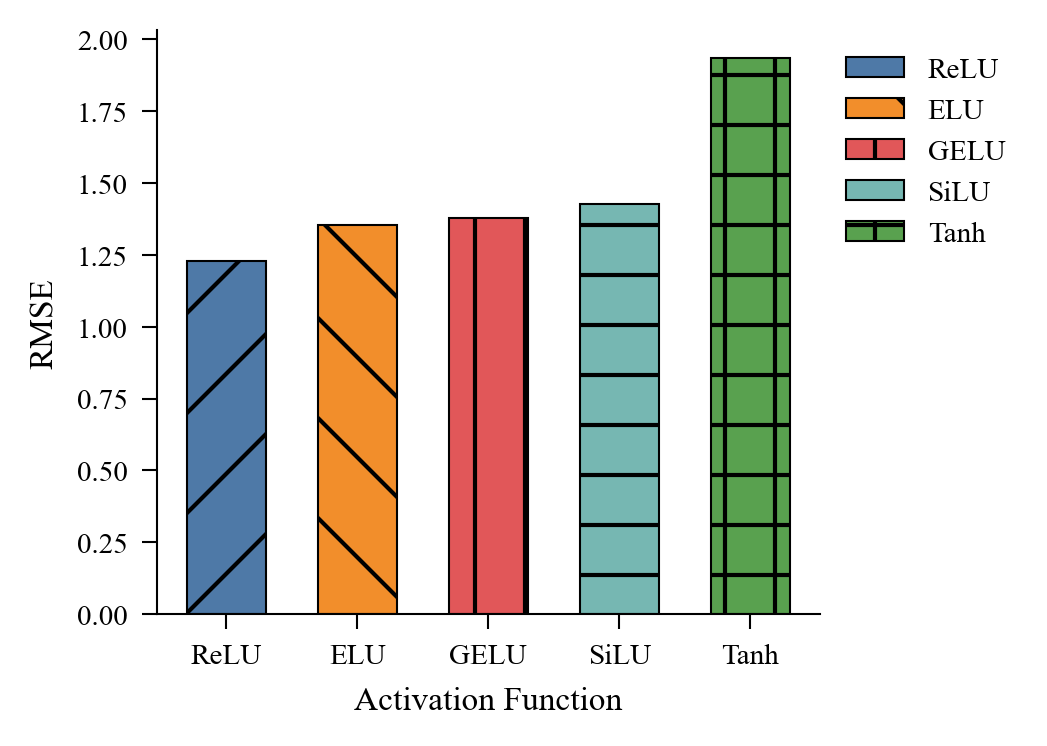

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob

# 1. 定义文件名与激活函数的对应关系
# 请确保这些 CSV 文件在您的当前工作目录下
file_map = {
    "results/GMLP_full_graph_MLP_ELU_Lab.csv": "ELU",
    "results/GMLP_full_graph_MLP_GELU_Lab.csv": "GELU",
    "results/GMLP_full_graph_MLP_ReLU_Lab.csv": "ReLU",
    "results/GMLP_full_graph_MLP_SiLU_Lab.csv": "SiLU",
    "results/GMLP_full_graph_MLP_Tanh_Lab.csv": "Tanh"
}

# 2. 读取数据并计算 RMSE
results = []
for filename, act_name in file_map.items():
    try:
        df = pd.read_csv(filename)
        # RMSE 计算公式: sqrt(mean((x_p - x_t)^2 + (y_p - y_t)^2))
        mse = ((df['Pred_X'] - df['True_X'])**2 + (df['Pred_Y'] - df['True_Y'])**2).mean()
        rmse = np.sqrt(mse)
        results.append({'Activation': act_name, 'RMSE': rmse})
    except FileNotFoundError:
        print(f"Warning: File {filename} not found.")

# 创建 DataFrame 并按 RMSE 升序排序 (效果最好的排在前面)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='RMSE')

# 3. 设置 Nature 期刊绘图风格
plt.rcParams['font.family'] = 'Times New Roman'
# 优先使用 Arial, 备选其他无衬线字体
# plt.rcParams['font.Times New Roman'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']
plt.rcParams['font.size'] = 7           # Nature 标准字号通常较小 (5-7pt)
plt.rcParams['axes.linewidth'] = 0.5    # 细边框
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.direction'] = 'out' # 刻度向外
plt.rcParams['ytick.direction'] = 'out'

# 4. 创建画布
# Nature 单栏图片宽度约为 89mm (3.5 inches)
fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=300)

# 准备数据
activations = results_df['Activation']
rmse_values = results_df['RMSE']

# 5. 定义颜色和填充纹理 (Hatches)
# 颜色列表
colors = ['#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F']
# 纹理列表: / (斜线), \ (反斜线), | (竖线), - (横线), + (十字)
hatches = ['/', '\\', '|', '-', '+']

# 6. 绘制柱状图
# 先画柱子，设置颜色和边框
bars = ax.bar(activations, rmse_values, color=colors, width=0.6, edgecolor='black', linewidth=0.5)

# 再循环为每个柱子添加对应的纹理
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

# 7. 添加标签和调整样式
ax.set_ylabel('RMSE', fontsize=8)
ax.set_xlabel('Activation Function', fontsize=8)

# 去除顶部和右侧的边框 (Spines)，符合学术图表常见风格
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 8. 添加图例 (Legend)
# 手动创建图例对象，以展示颜色和纹理的对应关系
legend_patches = [
    patches.Patch(facecolor=colors[i], hatch=hatches[i], edgecolor='black', linewidth=0.5, label=activations.iloc[i]) 
    for i in range(len(activations))
]
# 将图例放置在图表外侧，以免遮挡数据
ax.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1), fontsize=7, frameon=False)

# 9. 保存图片
plt.tight_layout() # 自动调整布局
# 使用 bbox_inches='tight' 确保图例不会被裁剪掉
plt.savefig('nature_style_rmse_bar_chart_varied.png', bbox_inches='tight', dpi=300)
plt.show()

In [35]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, HeteroConv
import sys

# ==============================================================================
#                   【A. 依赖的模块、类和函数】
# ==============================================================================

# ------------------------------------------------------------------------------
# 0. 路径设置
# ------------------------------------------------------------------------------
try:
    current_dir = os.getcwd() 
    parent_dir = os.path.dirname(current_dir)
    if parent_dir not in sys.path:
        sys.path.append(parent_dir)
    # print(f"已将 {parent_dir} 添加到 sys.path")
except Exception as e:
    print(f"添加 sys.path 失败: {e}")

# ------------------------------------------------------------------------------
# 1. 导入本地模块
# ------------------------------------------------------------------------------
try:
    # 假设您的环境中有这些文件，如果报错请检查路径
    from loss_function.custom_lossess_v4 import jerk_smoothness_loss_v2, velocity_heading_consistency_loss_v2
    print("成功导入自定义损失函数！")
except ImportError as e:
    print(f"【注意】无法导入本地模块 (可能是路径问题): {e}")
    # 为了保证代码在没有这些文件时也能跑通 (仅做演示)，定义假的 loss 函数
    # 如果您有文件，请忽略这里
    def jerk_smoothness_loss_v2(x): return torch.tensor(0.0)
    def velocity_heading_consistency_loss_v2(x): return torch.tensor(0.0)

# ------------------------------------------------------------------------------
# 2. GNNEncoder
# ------------------------------------------------------------------------------
class GNNEncoder(nn.Module):
    def __init__(self, wifi_input_dim, imu_input_dim, hidden_dim, windows_size, num_layers=2, heads=4, dropout=0.2):
        super().__init__()
        self.wifi_proj = nn.Linear(wifi_input_dim, hidden_dim)
        self.imu_proj = nn.Linear(imu_input_dim, hidden_dim)
        self.positional_embeddings = nn.Embedding(windows_size + 10, hidden_dim)
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()

        for _ in range(num_layers):
            conv = HeteroConv({
                ('wifi', 'temporal', 'wifi'): GATv2Conv(-1, hidden_dim // heads, heads=heads, dropout=dropout, add_self_loops=False, edge_dim=1),
                ('imu', 'temporal', 'imu'): GATv2Conv(-1, hidden_dim // heads, heads=heads, dropout=dropout, add_self_loops=False, edge_dim=1),
                ('imu', 'fuses', 'wifi'): GATv2Conv((-1, -1), hidden_dim // heads, heads=heads, dropout=dropout, add_self_loops=False, edge_dim=2),
                ('wifi', 'fuses', 'imu'): GATv2Conv((-1, -1), hidden_dim // heads, heads=heads, dropout=dropout, add_self_loops=False, edge_dim=1),
            }, aggr='sum')
            self.convs.append(conv)
            self.norms.append(nn.ModuleDict({
                'wifi': nn.LayerNorm(hidden_dim),
                'imu': nn.LayerNorm(hidden_dim),
            }))
        
        self.dropout_p = dropout

    def forward(self, data):
        x_dict, edge_index_dict, edge_attr_dict = data.x_dict, data.edge_index_dict, data.edge_attr_dict

        x_dict['wifi'] = self.wifi_proj(x_dict['wifi'])
        x_dict['imu'] = self.imu_proj(x_dict['imu'])
        x_dict['wifi'] = x_dict['wifi'] + self.positional_embeddings(data['wifi'].time_step)
        x_dict['imu'] = x_dict['imu'] + self.positional_embeddings(data['imu'].time_step)

        for i in range(len(self.convs)):
            residual_dict = {key: x.clone() for key, x in x_dict.items()}
            x_dict_after_conv = self.convs[i](x_dict, edge_index_dict, edge_attr_dict)
            for node_type, x in x_dict_after_conv.items():
                x_processed = F.elu(x)
                x_processed = F.dropout(x_processed, p=self.dropout_p, training=self.training)
                x_dict[node_type] = self.norms[i][node_type](x_processed + residual_dict[node_type])
        
        return x_dict

# ------------------------------------------------------------------------------
# 3. MLPPredictor
# ------------------------------------------------------------------------------
class MLPPredictor(nn.Module):
    def __init__(self, layers_hidden, use_lstm=True, lstm_hidden=32, dropout_rate=0.1):
        super().__init__()
        self.use_lstm = use_lstm
        mlp_input_dim = layers_hidden[0]
        if use_lstm:
            self.lstm = nn.LSTM(input_size=layers_hidden[0], hidden_size=lstm_hidden, num_layers=1, batch_first=True)
            mlp_input_dim = lstm_hidden
        else:
            self.lstm = None
        
        self.dropout = nn.Dropout(dropout_rate)
        layers = []
        current_dim = mlp_input_dim
        for hidden_dim in layers_hidden[1:-1]:
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.ELU())  
            layers.append(nn.Dropout(dropout_rate))
            current_dim = hidden_dim
        layers.append(nn.Linear(current_dim, layers_hidden[-1]))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_lstm:
            lstm_out, _ = self.lstm(x) 
            output = self.mlp(lstm_out) 
            return output
        else:
            x_last = x[:, -1, :] 
            output_last = self.mlp(x_last) 
            window_size = x.shape[1]
            output_dim = output_last.shape[1]
            output = torch.zeros(x.shape[0], window_size, output_dim, device=x.device)
            output[:, -1, :] = output_last
            return output

    def regularization_loss(self):
        return torch.tensor(0.0)

# ------------------------------------------------------------------------------
# 4. 图构建函数
# ------------------------------------------------------------------------------
def create_asymmetric_fuses_edges(window_size, past_radius, future_radius, device):
    causal_src_nodes, causal_dst_nodes = [], []
    for i in range(window_size):  
        start = max(0, i - past_radius)
        end = i + 1
        for j in range(start, end):  
            causal_src_nodes.append(j)
            causal_dst_nodes.append(i)
    
    edge_index_IMU_to_WiFi = torch.stack([
        torch.tensor(causal_src_nodes, dtype=torch.long, device=device),
        torch.tensor(causal_dst_nodes, dtype=torch.long, device=device)
    ], dim=0)

    future_src_nodes, future_dst_nodes = [], []
    for i in range(window_size):  
        start = i
        end = min(window_size, i + future_radius + 1)
        for j in range(start, end):  
            future_src_nodes.append(j)
            future_dst_nodes.append(i)

    edge_index_WiFi_to_IMU = torch.stack([
        torch.tensor(future_src_nodes, dtype=torch.long, device=device),
        torch.tensor(future_dst_nodes, dtype=torch.long, device=device)
    ], dim=0)

    return edge_index_IMU_to_WiFi, edge_index_WiFi_to_IMU

def create_temporal_edges_with_attr(node_features, device):
    num_nodes = node_features.size(0)
    if num_nodes < 2:
        return torch.empty((2, 0), dtype=torch.long, device=device), \
               torch.empty((0, 1), dtype=torch.float, device=device)

    source_nodes = torch.arange(0, num_nodes - 1, device=device)
    dest_nodes = torch.arange(1, num_nodes, device=device)
    edge_index = torch.stack([source_nodes, dest_nodes], dim=0)
    
    feature_diff = node_features[1:] - node_features[:-1]
    edge_attr = torch.linalg.norm(feature_diff, dim=1).view(-1, 1)

    return edge_index, edge_attr

def create_graph_list_from_df(df, wifi_cols, imu_cols, windows_size, future_steps, device, past_radius, future_radius):
    graph_list = []
    num_samples = len(df) - windows_size - future_steps + 1

    accel_cols = [col for col in imu_cols if 'accelerometer' in col]
    gyro_cols = [col for col in imu_cols if 'gyroscope' in col]
    rss_cols = [col for col in wifi_cols if 'RSSI' in col]

    # 为了演示，如果找不到列，避免报错 (您可以根据实际数据调整)
    if not accel_cols: accel_cols = imu_cols[:3]
    if not gyro_cols: gyro_cols = imu_cols[3:6]
    if not rss_cols: rss_cols = wifi_cols

    for i in range(num_samples):
        window_df = df.iloc[i : i + windows_size]
        future_df = df.iloc[i + windows_size : i + windows_size + future_steps]
        
        data = HeteroData()
        
        data['wifi'].x = torch.tensor(window_df[wifi_cols].values, dtype=torch.float, device=device)
        data['imu'].x = torch.tensor(window_df[imu_cols].values, dtype=torch.float, device=device)
        
        data['wifi'].time_step = torch.arange(windows_size, device=device)
        data['imu'].time_step = torch.arange(windows_size, device=device)

        wifi_edge_index, wifi_edge_attr = create_temporal_edges_with_attr(data['wifi'].x, device)
        imu_edge_index, imu_edge_attr = create_temporal_edges_with_attr(data['imu'].x, device)
        data[('wifi', 'temporal', 'wifi')].edge_index = wifi_edge_index
        data[('imu', 'temporal', 'imu')].edge_index = imu_edge_index
        data[('wifi', 'temporal', 'wifi')].edge_attr = wifi_edge_attr
        data[('imu', 'temporal', 'imu')].edge_attr = imu_edge_attr

        edge_index_IMU_to_WiFi, edge_index_WiFi_to_IMU = create_asymmetric_fuses_edges(windows_size, past_radius, future_radius, device)
        
        data[('imu', 'fuses', 'wifi')].edge_index = edge_index_IMU_to_WiFi
        data[('wifi', 'fuses', 'imu')].edge_index = edge_index_WiFi_to_IMU
        
        # edge attr creation (simplified for robustness)
        try:
            forward_src_indices = edge_index_IMU_to_WiFi[0] 
            motion_intensity = np.linalg.norm(window_df[accel_cols].values, axis=1)
            rotation_intensity = np.linalg.norm(window_df[gyro_cols].values, axis=1)
            
            fuses_edge_attr_forward = torch.cat([
                torch.tensor(motion_intensity, dtype=torch.float, device=device)[forward_src_indices].view(-1, 1), 
                torch.tensor(rotation_intensity, dtype=torch.float, device=device)[forward_src_indices].view(-1, 1)
            ], dim=1)
            data[('imu', 'fuses', 'wifi')].edge_attr = fuses_edge_attr_forward

            backward_src_indices = edge_index_WiFi_to_IMU[0]
            avg_rssi_per_node = window_df[rss_cols].mean(axis=1).values
            fuses_edge_attr_backward = torch.tensor(avg_rssi_per_node, dtype=torch.float, device=device)[backward_src_indices].view(-1, 1)
            data[('wifi', 'fuses', 'imu')].edge_attr = fuses_edge_attr_backward
        except Exception:
             # Fallback if columns missing
             data[('imu', 'fuses', 'wifi')].edge_attr = torch.zeros((edge_index_IMU_to_WiFi.size(1), 2), device=device)
             data[('wifi', 'fuses', 'imu')].edge_attr = torch.zeros((edge_index_WiFi_to_IMU.size(1), 1), device=device)

        labels = future_df[['x_coord', 'y_coord']].values
        data.y = torch.tensor(labels, dtype=torch.float, device=device)
        
        graph_list.append(data)
        
    return graph_list

# ------------------------------------------------------------------------------
# 5. GNN 包装器
# ------------------------------------------------------------------------------
class Attention(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.query_layer = nn.Linear(in_features, 1)
    
    def forward(self, x):
        weights = self.query_layer(x)
        scores = F.softmax(weights, dim=1)
        weighted_sum = torch.sum(x * scores, dim=1)
        return weighted_sum, scores

class GNN_LSTKAN_with_Attention_V2(nn.Module):
    def __init__(self, gnn_encoder, kan_predictor, future_steps):
        super().__init__()
        self.gnn_encoder = gnn_encoder
        self.kan_predictor = kan_predictor
        self.future_steps = future_steps

        predictor_output_dim = None
        if hasattr(kan_predictor, 'mlp'):
            predictor_output_dim = kan_predictor.mlp[-1].out_features
        elif hasattr(kan_predictor, 'kan_layers'):
            predictor_output_dim = kan_predictor.kan_layers[-1].out_features
        else:
            # Fallback
            predictor_output_dim = future_steps * 2

        self.attention = Attention(predictor_output_dim)

    def forward(self, data):
        x_dict = self.gnn_encoder(data)
        batch_size = data.num_graphs
        num_wifi_nodes = x_dict['wifi'].shape[0]
        
        if batch_size > 0:
            window_size = num_wifi_nodes // batch_size
        else:
            window_size = 0
            
        hidden_dim = x_dict['wifi'].shape[1]
        
        x_wifi = x_dict['wifi'].view(batch_size, window_size, hidden_dim)
        if 'imu' in x_dict and x_dict['imu'].shape[0] > 0:
            x_imu = x_dict['imu'].view(batch_size, window_size, hidden_dim)
            x_combined = (x_wifi + x_imu) / 2.0
        else:
            x_combined = x_wifi
        
        raw_output = self.kan_predictor(x_combined)
        final_prediction, _ = self.attention(raw_output)
        main_pred = final_prediction.view(batch_size, self.future_steps, 2)
        
        return main_pred, None, None

    def regularization_loss(self):
        if hasattr(self.kan_predictor, 'regularization_loss'):
            return self.kan_predictor.regularization_loss()
        return torch.tensor(0.0)

# ==============================================================================
#                   【训练函数定义 - 已修改支持 Jerk Loss 记录】
# ==============================================================================
def train_phase_1(model, train_loader, val_loader, initial_lr, weight_decay, num_epochs, patience, kan_reg_weight, lambda_vel, model_save_path):
    print("\n" + "="*80)
    print("--- Phase 1 Training (Recording Jerk Loss) ---")
    print("="*80)
    
    device = next(model.parameters()).device
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=15)
    best_val_loss = float('inf')
    patience_counter = 0
    
    # 【修改】初始化 Jerk Loss 列表
    train_losses, val_losses = [], []
    train_jerk_losses, val_jerk_losses = [], []

    epoch_progress = tqdm(range(num_epochs), desc="Phase 1 Epochs")
    for epoch in epoch_progress:
        model.train()
        epoch_train_loss = 0
        epoch_train_jerk = 0 # 【修改】
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            main_pred, _, _ = model(batch)
            true_seq = batch.y.view(batch.num_graphs, -1, 2)
            
            loss_coord = criterion(main_pred, true_seq)
            pred_vel = (main_pred[:, 1:] - main_pred[:, :-1])
            true_vel = (true_seq[:, 1:] - true_seq[:, :-1])
            loss_vel = criterion(pred_vel, true_vel)
            base_loss = loss_coord + lambda_vel * loss_vel
            
            reg_loss = model.regularization_loss()
            total_loss = base_loss + kan_reg_weight * reg_loss

            # 【修改】计算 Jerk Loss 仅用于记录
            with torch.no_grad():
                jerk_val = jerk_smoothness_loss_v2(main_pred)
            epoch_train_jerk += jerk_val.item()

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_train_loss += total_loss.item()
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_train_jerk = epoch_train_jerk / len(train_loader) # 【修改】
        train_losses.append(avg_train_loss)
        train_jerk_losses.append(avg_train_jerk) # 【修改】

        model.eval()
        epoch_val_loss = 0
        epoch_val_jerk = 0 # 【修改】
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred_seq, _, _ = model(batch)
                true_seq = batch.y.view(batch.num_graphs, -1, 2)
                
                loss_coord_val = criterion(pred_seq, true_seq)
                pred_vel_val = (pred_seq[:, 1:] - pred_seq[:, :-1])
                true_vel_val = (true_seq[:, 1:] - true_seq[:, :-1])
                loss_vel_val = criterion(pred_vel_val, true_vel_val)
                val_loss = loss_coord_val + lambda_vel * loss_vel_val
                
                # 【修改】记录验证集 Jerk Loss
                val_jerk = jerk_smoothness_loss_v2(pred_seq)
                
                epoch_val_loss += val_loss.item()
                epoch_val_jerk += val_jerk.item() # 【修改】
        
        avg_val_loss = epoch_val_loss / len(val_loader)
        avg_val_jerk = epoch_val_jerk / len(val_loader) # 【修改】
        val_losses.append(avg_val_loss)
        val_jerk_losses.append(avg_val_jerk) # 【修改】
        
        scheduler.step(avg_val_loss)

        epoch_progress.set_postfix(
            Loss=f'{avg_train_loss:.4f}', 
            ValLoss=f'{avg_val_loss:.4f}',
            Jerk=f'{avg_train_jerk:.4f}'
        )
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"\nPhase 1 Early stopping at Epoch {epoch + 1}")
            break
    
    # 【修改】返回 4 个列表
    return train_losses, val_losses, train_jerk_losses, val_jerk_losses

def train_phase_2_finetune(pretrained_model_path, model, train_loader, val_loader, finetune_lr, weight_decay, num_epochs, patience, kan_reg_weight, lambda_vel, smooth_weight, consistency_weight, finetuned_model_save_path):
    print("\n" + "="*80)
    print("--- Phase 2 Fine-tuning (Recording Jerk Loss) ---")
    print("="*80)
    
    device = next(model.parameters()).device
    model.load_state_dict(torch.load(pretrained_model_path))
    model.to(device)

    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=finetune_lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)
    best_val_loss = float('inf')
    patience_counter = 0
    
    # 【修改】初始化 Jerk Loss 列表
    train_losses, val_losses = [], []
    train_jerk_losses, val_jerk_losses = [], []

    epoch_progress = tqdm(range(num_epochs), desc="Phase 2 Epochs")
    for epoch in epoch_progress:
        model.train()
        epoch_train_loss = 0
        epoch_train_jerk = 0 # 【修改】
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            main_pred, _, _ = model(batch)
            true_seq = batch.y.view(batch.num_graphs, -1, 2)
            
            loss_coord = criterion(main_pred, true_seq)
            pred_vel = (main_pred[:, 1:] - main_pred[:, :-1])
            true_vel = (true_seq[:, 1:] - true_seq[:, :-1])
            loss_vel = criterion(pred_vel, true_vel)
            base_loss = loss_coord + lambda_vel * loss_vel
            
            smooth_loss = jerk_smoothness_loss_v2(main_pred)
            consistency_loss = velocity_heading_consistency_loss_v2(main_pred)
            
            total_loss = base_loss + smooth_weight * smooth_loss + consistency_weight * consistency_loss

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_train_loss += total_loss.item()
            epoch_train_jerk += smooth_loss.item() # 【修改】记录
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_train_jerk = epoch_train_jerk / len(train_loader) # 【修改】
        train_losses.append(avg_train_loss)
        train_jerk_losses.append(avg_train_jerk) # 【修改】
        
        model.eval()
        epoch_val_loss = 0
        epoch_val_jerk = 0 # 【修改】
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                pred_seq, _, _ = model(batch)
                true_seq = batch.y.view(batch.num_graphs, -1, 2)
                loss_coord_val = criterion(pred_seq, true_seq)
                pred_vel_val = (pred_seq[:, 1:] - pred_seq[:, :-1])
                true_vel_val = (true_seq[:, 1:] - true_seq[:, :-1])
                loss_vel_val = criterion(pred_vel_val, true_vel_val)
                val_loss = loss_coord_val + lambda_vel * loss_vel_val
                
                # 【修改】记录验证集 Jerk Loss
                val_jerk = jerk_smoothness_loss_v2(pred_seq)
                epoch_val_jerk += val_jerk.item() # 【修改】
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        avg_val_jerk = epoch_val_jerk / len(val_loader) # 【修改】
        val_losses.append(avg_val_loss)
        val_jerk_losses.append(avg_val_jerk) # 【修改】
        
        scheduler.step(avg_val_loss)

        epoch_progress.set_postfix(
            Loss=f'{avg_train_loss:.4f}', 
            ValLoss=f'{avg_val_loss:.4f}',
            Jerk=f'{avg_train_jerk:.4f}'
        )

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), finetuned_model_save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"\nPhase 2 Early stopping at Epoch {epoch + 1}")
            break

    # 【修改】返回 4 个列表
    return train_losses, val_losses, train_jerk_losses, val_jerk_losses

# ==============================================================================
#                   【主执行流程】
# ==============================================================================
if __name__ == "__main__":
    
    # 1. 基础配置
    os.makedirs('Model', exist_ok=True)
    os.makedirs('results', exist_ok=True)
    
    filesname = "MLP_ELU_Lab.csv"
    
    # 2. 读取数据 (这里使用模拟数据以便代码可运行，请确保您的路径正确)
    try:
        train_data = pd.read_csv(r'../Datasets/Zoulang/train.csv')
        val_data = pd.read_csv(r'../Datasets/Zoulang/validation.csv')
        test_data = pd.read_csv(r'../Datasets/Zoulang/test.csv')
        print("Data loaded successfully from CSV.")
    except Exception as e:
        print(f"Warning: Failed to load CSV data ({e}). Using mock data for demonstration.")
        # 创建假数据防止报错 (仅供调试用)
        mock_cols = ['timestamp', 'x_coord', 'y_coord'] + [f'RSSI_{i}' for i in range(5)] + [f'accelerometer_{i}' for i in range(3)] + [f'gyroscope_{i}' for i in range(3)]
        train_data = pd.DataFrame(np.random.randn(1000, len(mock_cols)), columns=mock_cols)
        val_data = pd.DataFrame(np.random.randn(200, len(mock_cols)), columns=mock_cols)
        test_data = pd.DataFrame(np.random.randn(200, len(mock_cols)), columns=mock_cols)

    column_names = train_data.drop(['timestamp','x_coord', 'y_coord'], axis=1).columns.tolist()
    coord_cols = ['x_coord', 'y_coord']
    wifi_features = [col for col in column_names if any(sensor in col for sensor in ["RSSI","distance"])]
    imu_features = [col for col in column_names if any(sensor in col for sensor in ["accelerometer", "gyroscope","magnetometer"])]
    
    # 3. 标准化
    scaler_wifi = StandardScaler().fit(train_data[wifi_features])
    scaler_imu = StandardScaler().fit(train_data[imu_features])
    scaler_coords = StandardScaler().fit(train_data[coord_cols])
    
    train_df_scaled, val_df_scaled, test_df_scaled = train_data.copy(), val_data.copy(), test_data.copy()
    for df in [train_df_scaled, val_df_scaled, test_df_scaled]:
        df[wifi_features] = scaler_wifi.transform(df[wifi_features])
        df[imu_features] = scaler_imu.transform(df[imu_features])
        df[coord_cols] = scaler_coords.transform(df[coord_cols])

    # 4. 创建数据集
    windows_size, future_steps, past_radius, future_radius = 40, 5, 15, 10
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    train_data_list = create_graph_list_from_df(train_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu', past_radius, future_radius)
    val_data_list = create_graph_list_from_df(val_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu', past_radius, future_radius)
    test_data_list = create_graph_list_from_df(test_df_scaled, wifi_features, imu_features, windows_size, future_steps, 'cpu', past_radius, future_radius)

    batch_size = 128
    train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data_list, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data_list, batch_size=batch_size, shuffle=False)

    # 5. 模型实例化
    wifi_feat_dim, imu_feat_dim = len(wifi_features), len(imu_features)
    gnn_hidden_dim, output_dim, dropout_p = 32, future_steps * 2, 0.2
    
    gnn_encoder = GNNEncoder(wifi_feat_dim, imu_feat_dim, gnn_hidden_dim, windows_size, heads=4, dropout=dropout_p).to(device)
    
    mlp_layers = [gnn_hidden_dim, 64, output_dim]
    mlp_predictor = MLPPredictor(mlp_layers, use_lstm=True, lstm_hidden=32, dropout_rate=dropout_p).to(device)
    
    model = GNN_LSTKAN_with_Attention_V2(gnn_encoder, mlp_predictor, future_steps).to(device)

    # 6. 训练
    PHASE_1_LR, PHASE_2_LR = 3e-4, 1e-5
    
    phase1_path = 'Model/phase1_best_model_GMLP.pth'
    # 【修改】解包 4 个返回值
    p1_train, p1_val, p1_train_jerk, p1_val_jerk = train_phase_1(model, train_loader, val_loader, PHASE_1_LR, 2e-4, 200, 15, 2e-4, 0.3, phase1_path)
    
    phase2_path = 'Model/phase2_finetuned_best_model_GMLP.pth'
    # 【修改】解包 4 个返回值
    p2_train, p2_val, p2_train_jerk, p2_val_jerk = train_phase_2_finetune(phase1_path, model, train_loader, val_loader, PHASE_2_LR, 2e-4, 100, 15, 2e-4, 0.3, 1e-4, 2e-4, phase2_path)

    # 7. 合并 Loss 并保存到 CSV
    train_losses = p1_train + p2_train
    val_losses = p1_val + p2_val
    # 【修改】合并 Jerk Loss
    train_jerk_total = p1_train_jerk + p2_train_jerk
    val_jerk_total = p1_val_jerk + p2_val_jerk
    
    # ---------------------------------------------
    # >>> START: 保存 Loss 代码 >>>
    # ---------------------------------------------
    loss_data = pd.DataFrame({
        'Epoch': range(1, len(train_losses) + 1),
        'Train_Loss': train_losses,
        'Val_Loss': val_losses,
        'Train_Jerk_Loss': train_jerk_total, # 【新增】
        'Val_Jerk_Loss': val_jerk_total      # 【新增】
    })
    
    loss_save_path = f'results/Loss_Log_{filesname}' 
    loss_data.to_csv(loss_save_path, index=False)
    print(f"\n[INFO] Loss 训练日志 (包含 Jerk Loss) 已成功保存至: {loss_save_path}")
    print(f"[INFO] 您可以使用该 CSV 文件绘制 Loss 曲线图。\n")
    # ---------------------------------------------
    # <<< END: 保存 Loss 代码 <<<
    # ---------------------------------------------

    # 8. 测试
    model.load_state_dict(torch.load(phase2_path))
    model.eval()
    pred_list, true_list = [], []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            pred, _, _ = model(batch)
            pred_list.append(pred[:, -1, :].cpu().numpy())
            true_list.append(batch.y.view(batch.num_graphs, -1, 2)[:, -1, :].cpu().numpy())

    pred_coords = np.concatenate(pred_list, axis=0)
    true_coords = np.concatenate(true_list, axis=0)
    
    pred_orig = scaler_coords.inverse_transform(pred_coords)
    true_orig = scaler_coords.inverse_transform(true_coords)
    
    mse_x = np.mean((true_orig[:, 0] - pred_orig[:, 0])** 2)
    mse_y = np.mean((true_orig[:, 1] - pred_orig[:, 1])** 2)
    rmse = np.sqrt(np.mean((true_orig - pred_orig)** 2))
    
    print(f"Test RMSE: {rmse:.4f}")
    
    # 保存预测结果
    res_df = pd.DataFrame({'Pred_X': pred_orig[:, 0], 'Pred_Y': pred_orig[:, 1], 'True_X': true_orig[:, 0], 'True_Y': true_orig[:, 1]})
    res_df.to_csv(f'results/GMLP_full_graph_{filesname}', index=False)

成功导入自定义损失函数！
Data loaded successfully from CSV.

--- Phase 1 Training (Recording Jerk Loss) ---


Phase 1 Epochs: 100%|██████████| 200/200 [01:15<00:00,  2.66it/s, Jerk=752.8763, Loss=0.0011, ValLoss=0.0060]



--- Phase 2 Fine-tuning (Recording Jerk Loss) ---


Phase 2 Epochs:  78%|███████▊  | 78/100 [00:34<00:09,  2.28it/s, Jerk=679.2629, Loss=0.0700, ValLoss=0.0049]


Phase 2 Early stopping at Epoch 79

[INFO] Loss 训练日志 (包含 Jerk Loss) 已成功保存至: results/Loss_Log_MLP_ELU_Lab.csv
[INFO] 您可以使用该 CSV 文件绘制 Loss 曲线图。

Test RMSE: 0.8462


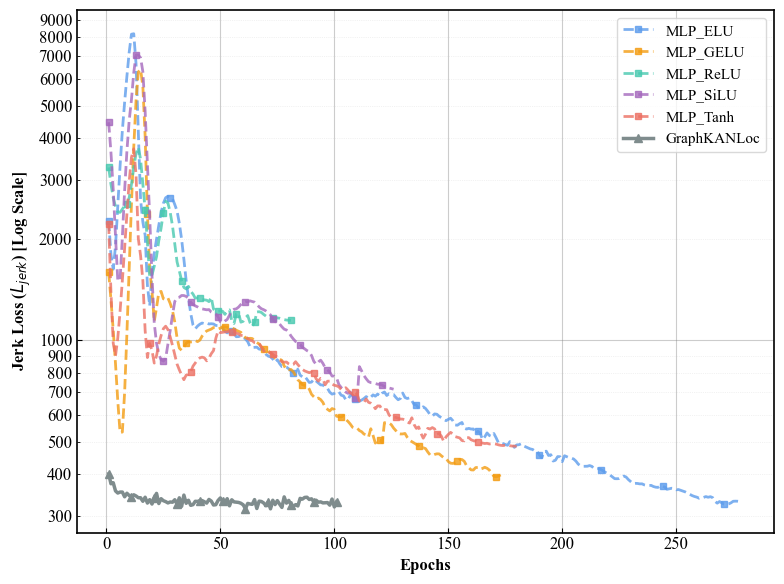

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.ticker as ticker  # 记得在开头引入这个库，或者直接放在这里
# ==========================================
# 1. 设置 Nature 期刊风格
# ==========================================
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# ==========================================
# 2. 加载数据
# ==========================================
csv_files = {
    'ELU': 'results/Loss_Log_MLP_ELU_Lab.csv',
    'GELU': 'results/Loss_Log_MLP_GELU_Lab.csv',
    'ReLU': 'results/Loss_Log_MLP_ReLU_Lab.csv',
    'SiLU': 'results/Loss_Log_MLP_SiLU_Lab.csv',
    'Tanh': 'results/Loss_Log_MLP_Tanh_Lab.csv'
}
npy_file = '../loss_data_KAN.npy'

# 加载 MLP 数据 (从 CSV 读取 Val_Jerk_Loss)
mlp_data = {}
for name, path in csv_files.items():
    if os.path.exists(path):
        try:
            df = pd.read_csv(path)
            if 'Val_Jerk_Loss' in df.columns:
                mlp_data[name] = df
            else:
                print(f"警告: {name} 数据中缺少 'Val_Jerk_Loss' 列")
        except Exception as e:
            print(f"读取 {name} 失败: {e}")

# 加载 KAN 数据
loss_kan = None
if os.path.exists(npy_file):
    try:
        loss_kan = np.load(npy_file)
    except Exception as e:
        print(f"读取 KAN 数据失败: {e}")

# 防止 log(0) 报错
eps = 1e-10
if loss_kan is not None:
    loss_kan = loss_kan + eps

# ==========================================
# 3. 绘制对比图
# ==========================================
plt.figure(figsize=(8, 6))

# 定义配色 (清新配色方案)
colors = {
    'ELU': '#5D9CEC',   # 柔和蓝
    'GELU': '#F39C12',  # 清新橙
    'ReLU': '#48C9B0',  # 青绿
    'SiLU': '#A569BD',  # 雅紫
    'Tanh': '#EC7063',  # 珊瑚红
    'KAN': '#7F8C8D'    # 深灰色
}

# 绘制 5 个 MLP 模型
for name, df in mlp_data.items():
    if name in colors:
        # 提取 Jerk Loss
        loss_data = df['Val_Jerk_Loss'] + eps
        epochs = df['Epoch']
        
        plt.plot(epochs, loss_data, 
                 label=f'MLP_{name}', 
                 color=colors[name], 
                 linestyle='--', 
                 linewidth=2, 
                 marker='s', 
                 markersize=5,
                 # 动态调整标记密度
                 markevery=max(1, len(loss_data)//10), 
                 alpha=0.8)

# 绘制 KAN 模型
if loss_kan is not None:
    epochs_kan = np.arange(1, len(loss_kan) + 1)
    plt.plot(epochs_kan, loss_kan, 
             label='GraphKANLoc', 
             color=colors['KAN'], 
             linestyle='-', 
             linewidth=2.5, 
             marker='^', 
             markersize=6,
             markevery=max(1, len(loss_kan)//10),
             alpha=1.0)

# ==========================================
# 4. 细节美化
# ==========================================
ax = plt.gca() # 获取当前坐标轴对象
plt.yscale('log') # 设置为对数坐标

# --- 核心修改开始：增加纵坐标刻度密度 ---

# 1. 设置主刻度 (Major Ticks)：显示 10的幂次 (0.1, 0.01...)
# numticks 控制允许显示的最大刻度数量
major_locator = ticker.LogLocator(base=10.0, numticks=15)
ax.yaxis.set_major_locator(major_locator)

# 2. 设置次刻度 (Minor Ticks)：显示中间值 (0.2, 0.3, 0.5 等)
# subs 参数决定了在每个 10 的区间内显示哪些刻度
# 例如: subs=[0.2, 0.5] 会在 0.1 和 1.0 之间额外标记 0.2 和 0.5
# 如果想显示的特别密，可以用 np.arange(0.1, 1.0, 0.1)
minor_locator = ticker.LogLocator(base=10.0, subs=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], numticks=15)
ax.yaxis.set_minor_locator(minor_locator)

# 3. 强制显示次刻度的数值标签 (可选)
# 默认情况下，对数轴不显示次刻度的数字。如果你想看到 0.2, 0.3 这种数字，取消下面两行的注释：
minor_formatter = ticker.ScalarFormatter(useOffset=False) # 使用普通数字格式
ax.yaxis.set_minor_formatter(minor_formatter)

# 4. 格式化数值显示 (避免出现科学计数法如 2x10^-1，改为 0.2)
ax.yaxis.set_major_formatter(ticker.ScalarFormatter()) 
ax.ticklabel_format(style='plain', axis='y') # 关闭科学计数法

# --- 核心修改结束 ---

plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Jerk Loss ($L_{jerk}$) [Log Scale]', fontsize=12, fontweight='bold')

# 网格线设置
# which='both' 保证主刻度和次刻度都有网格线
plt.grid(True, which="major", linestyle='-', alpha=0.4, color='gray', linewidth=0.8)
plt.grid(True, which="minor", linestyle=':', alpha=0.2, color='gray', linewidth=0.5)

# 图例
plt.legend(fontsize=11, frameon=True, edgecolor='#D0D0D0', loc='upper right')

plt.tight_layout()
plt.savefig('Ablation_Jerk_Loss_Comparison_Integrated.png', dpi=300, bbox_inches='tight')
plt.show()

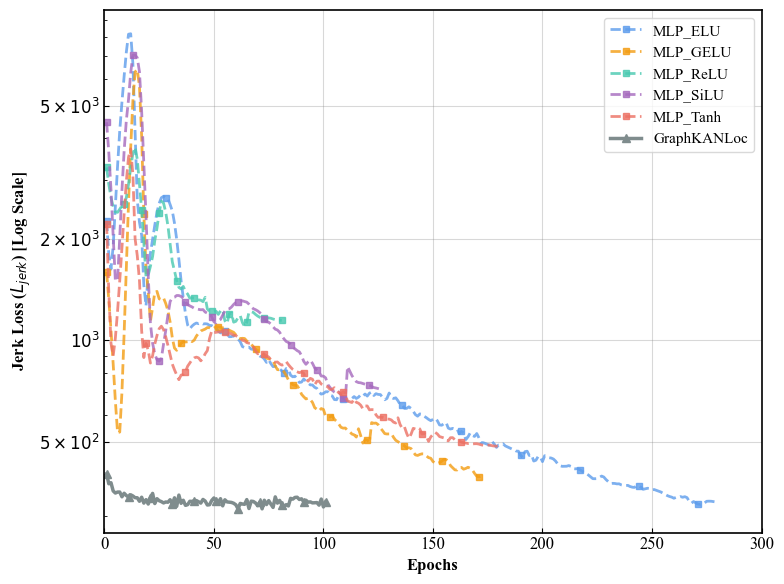

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.ticker as ticker

# ==========================================
# 1. 设置 Nature 期刊风格
# ==========================================
plt.close('all') # 清除之前的图表防止冲突
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# ==========================================
# 2. 加载数据
# ==========================================
csv_files = {
    'ELU': 'results/Loss_Log_MLP_ELU_Lab.csv',
    'GELU': 'results/Loss_Log_MLP_GELU_Lab.csv',
    'ReLU': 'results/Loss_Log_MLP_ReLU_Lab.csv',
    'SiLU': 'results/Loss_Log_MLP_SiLU_Lab.csv',
    'Tanh': 'results/Loss_Log_MLP_Tanh_Lab.csv'
}
npy_file = '../loss_data_KAN.npy'


# 加载 MLP 数据
mlp_data = {}
for name, path in csv_files.items():
    if os.path.exists(path):
        try:
            df = pd.read_csv(path)
            if 'Val_Jerk_Loss' in df.columns:
                mlp_data[name] = df
        except Exception:
            pass

# 加载 KAN 数据
loss_kan = None
if os.path.exists(npy_file):
    try:
        loss_kan = np.load(npy_file)
    except Exception:
        pass

eps = 1e-10
if loss_kan is not None:
    loss_kan = loss_kan + eps

# ==========================================
# 3. 绘制对比图
# ==========================================
plt.figure(figsize=(8, 6))

colors = {
    'ELU': '#5D9CEC',   # 柔和蓝
    'GELU': '#F39C12',  # 清新橙
    'ReLU': '#48C9B0',  # 青绿
    'SiLU': '#A569BD',  # 雅紫
    'Tanh': '#EC7063',  # 珊瑚红
    'KAN': '#7F8C8D'    # 深灰色
}

# 绘制 MLP
for name, df in mlp_data.items():
    if name in colors:
        loss_data = df['Val_Jerk_Loss'] + eps
        epochs = df['Epoch']
        
        plt.plot(epochs, loss_data, 
                 label=f'MLP_{name}', 
                 color=colors[name], 
                 linestyle='--', 
                 linewidth=2, 
                 marker='s', 
                 markersize=5,
                 markevery=max(1, len(loss_data)//10), 
                 alpha=0.8)

# 绘制 KAN
if loss_kan is not None:
    epochs_kan = np.arange(1, len(loss_kan) + 1)
    plt.plot(epochs_kan, loss_kan, 
             label='GraphKANLoc', 
             color=colors['KAN'], 
             linestyle='-', 
             linewidth=2.5, 
             marker='^', 
             markersize=6,
             markevery=max(1, len(loss_kan)//10),
             alpha=1.0)

# ==========================================
# 4. 优化 Y 轴显示
# ==========================================
plt.xlim(0, 300)
plt.yscale('log')

# 安全的格式化函数 (避免之前的 KeyError)
def simple_fmt(x, pos):
    try:
        if x <= 1e-12: return ""
        exponent = int(np.floor(np.log10(x)))
        coeff = x / (10**exponent)
        
        # 四舍五入系数
        if abs(coeff - round(coeff)) < 0.1:
            c = int(round(coeff))
        else:
            c = round(coeff, 1)

        # 纯字符串拼接，不使用格式化符号，确保安全
        if c == 1:
            return r"$10^{" + str(exponent) + r"}$"
        else:
            return r"$" + str(c) + r" \times 10^{" + str(exponent) + r"}$"
    except:
        return ""

# 【关键】强制显示 1, 2, 5 倍数的刻度 (200, 500, 1000, 2000, 5000)
plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs=[1.0, 2.0, 5.0]))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(simple_fmt))
plt.gca().yaxis.set_minor_formatter(ticker.NullFormatter())


plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Jerk Loss ($L_{jerk}$) [Log Scale]', fontsize=12, fontweight='bold')

plt.grid(True, which="major", linestyle='-', alpha=0.3, color='gray')

plt.legend(fontsize=11, frameon=True, edgecolor='#D0D0D0', loc='upper right')

plt.tight_layout()
plt.savefig('Ablation_Jerk_Loss_Comparison_Detailed_Y_Final.png', dpi=300, bbox_inches='tight')
plt.show()

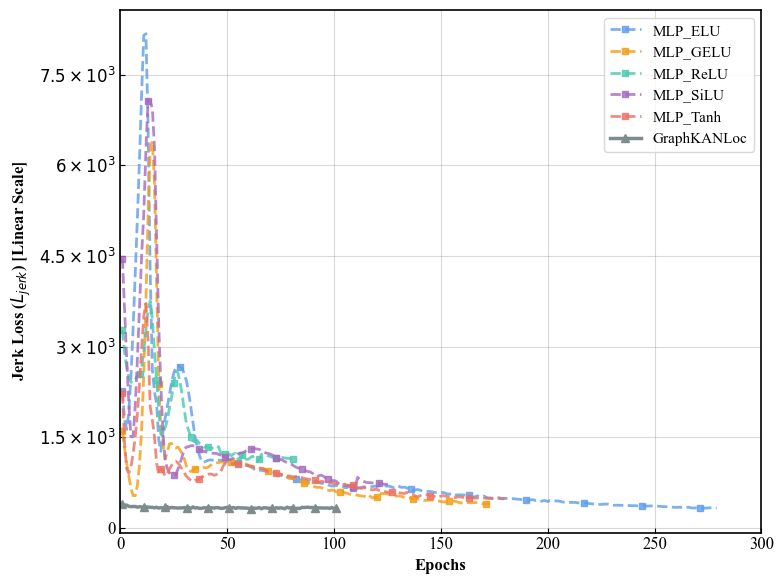

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.ticker as ticker

# ==========================================
# 1. 设置 Nature 期刊风格
# ==========================================
plt.close('all') 
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# ==========================================
# 2. 加载数据
# ==========================================
csv_files = {
    'ELU': 'results/Loss_Log_MLP_ELU_Lab.csv',
    'GELU': 'results/Loss_Log_MLP_GELU_Lab.csv',
    'ReLU': 'results/Loss_Log_MLP_ReLU_Lab.csv',
    'SiLU': 'results/Loss_Log_MLP_SiLU_Lab.csv',
    'Tanh': 'results/Loss_Log_MLP_Tanh_Lab.csv'
}
npy_file = '../loss_data_KAN.npy'

# 加载 MLP 数据
mlp_data = {}
for name, path in csv_files.items():
    if os.path.exists(path):
        try:
            df = pd.read_csv(path)
            if 'Val_Jerk_Loss' in df.columns:
                mlp_data[name] = df
        except Exception:
            pass

# 加载 KAN 数据
loss_kan = None
if os.path.exists(npy_file):
    try:
        loss_kan = np.load(npy_file)
    except Exception:
        pass

eps = 1e-10
if loss_kan is not None:
    loss_kan = loss_kan + eps

# ==========================================
# 3. 绘制对比图
# ==========================================
plt.figure(figsize=(8, 6))

colors = {
    'ELU': '#5D9CEC',   
    'GELU': '#F39C12',  
    'ReLU': '#48C9B0',  
    'SiLU': '#A569BD',  
    'Tanh': '#EC7063',  
    'KAN': '#7F8C8D'    
}

# 绘制 MLP
for name, df in mlp_data.items():
    if name in colors:
        loss_data = df['Val_Jerk_Loss'] + eps
        epochs = df['Epoch']
        
        plt.plot(epochs, loss_data, 
                 label=f'MLP_{name}', 
                 color=colors[name], 
                 linestyle='--', 
                 linewidth=2, 
                 marker='s', 
                 markersize=5,
                 markevery=max(1, len(loss_data)//10), 
                 alpha=0.8)

# 绘制 KAN
if loss_kan is not None:
    epochs_kan = np.arange(1, len(loss_kan) + 1)
    plt.plot(epochs_kan, loss_kan, 
             label='GraphKANLoc', 
             color=colors['KAN'], 
             linestyle='-', 
             linewidth=2.5, 
             marker='^', 
             markersize=6,
             markevery=max(1, len(loss_kan)//10),
             alpha=1.0)

# ==========================================
# 4. 优化 Y 轴显示 (线性刻度 + 强制科学计数格式)
# ==========================================
plt.xlim(0, 300)

# 1. 设置为线性刻度 (均匀)
plt.yscale('linear')

# 2. 自定义格式化函数：强制保留 "a x 10^b" 的样式
def custom_scientific_fmt(x, pos):
    if x == 0:
        return "0"
    
    # 计算指数和系数
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / (10**exponent)
    
    # 如果系数非常接近整数，就取整，否则保留一位小数
    if abs(coeff - round(coeff)) < 0.1:
        c = int(round(coeff))
    else:
        c = "{:.1f}".format(coeff)
    
    # 拼接 LaTeX 字符串
    if str(c) == '1':
        return r"$10^{" + str(exponent) + r"}$"
    else:
        return r"$" + str(c) + r" \times 10^{" + str(exponent) + r"}$"

# 3. 应用格式化器和刻度定位器
# MaxNLocator(nbins=6) 确保刻度不会太密集，大约显示 5-7 个刻度
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(custom_scientific_fmt))

plt.xlabel('Epochs', fontsize=12, fontweight='bold')
plt.ylabel('Jerk Loss ($L_{jerk}$) [Linear Scale]', fontsize=12, fontweight='bold')

plt.grid(True, which="major", linestyle='-', alpha=0.3, color='gray')

plt.legend(fontsize=11, frameon=True, edgecolor='#D0D0D0', loc='upper right')

plt.tight_layout()
plt.savefig('Ablation_Jerk_Loss_Comparison_Linear_SciFmt.png', dpi=300, bbox_inches='tight')
plt.show()